## Fundamental imports, agents assessment and submission functions

In [5]:
import sys
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import numpy as np
import random
import time
import inspect
import os
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))


def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    


def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

['random', 'negamax']


In [3]:
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

In [6]:
from dqn_agent import Agent
agent_connect = Agent(state_size=42, action_size=7, seed=0)

In [32]:
env = ConnectFourGym(agent2='negamax')

In [33]:
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (6, 7, 1)
Number of actions:  7


In [34]:
state = env.reset()

In [35]:
state.reshape(-1).shape

(42,)

In [36]:
state = state.reshape(-1)

In [37]:
agent_connect.act(state.reshape(-1))

3

In [29]:
params = list(agent_connect.qnetwork_local.parameters())
s = 0
for tensor in params:
    print(tensor.size())
    s += tensor.numel()
print(s)

torch.Size([64, 42])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([7, 64])
torch.Size([7])
7367


In [14]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = state.reshape(-1)
        score = 0
        for t in range(max_t):
            action = agent_connect.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.reshape(-1)
            
            agent_connect.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.99:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent_connect.qnetwork_local.state_dict(), 'check_success_connect_dqn.pth')
            break
    torch.save(agent_connect.qnetwork_local.state_dict(), 'check_connect_dqn.pth')
    return scores

Episode 100	Average Score: -2.02
Episode 200	Average Score: -2.21

Elapsed time:  180.8103368282318


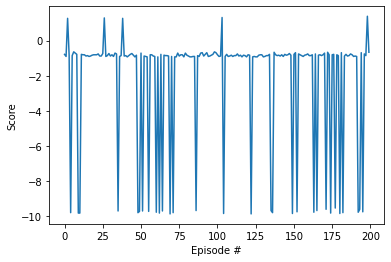

In [39]:
t0 = time.time()
scores = dqn(n_episodes=200)
print("\nElapsed time: ", time.time() - t0)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Rendering a play

## Playing against an agent

In [ ]:
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.play(['random', None], width=500, height=450)

# Loading previously developed agents - Classic Agents

In [ ]:
from submission_test import my_agent_test as level_two_agent
from submission_one_step_agent import my_agent_one_step_5_heuristic as one_step_agent
from submission_alphabeta_agent_with_improved_heuristics_three_step import alphabeta_agent_with_improved_heuristics as three_step_agent

In [ ]:
t = time.time()
get_win_percentages(level_two_agent, one_step_agent, n_rounds=1)
delta = time.time() - t
print(delta)

In [ ]:
t = time.time()
get_win_percentages(three_step_agent, one_step_agent, n_rounds=1)
delta = time.time() - t
print(delta)

# Reinforcement Learning

In [17]:
def agent_con1(obs, config):
    #with open('history', mode='a') as file:
    #file.write(f'\n    data = {learner.policy._get_data()}\n')
        #file.write(f'    obs = {obs}\n config={config}')
    # Use the best model to select a column
    action = agent_connect.act(np.array(obs['board']).reshape(-1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(action)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(action)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [42]:
t = time.time()
get_win_percentages(agent_con1, 'random', n_rounds=100)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.61
Agent 2 Win Percentage: 0.39
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
2.2102091312408447


In [43]:
t = time.time()
get_win_percentages('negamax', agent_con1, n_rounds=10)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.9
Agent 2 Win Percentage: 0.1
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
9.340630054473877


# Work on submission

In [ ]:
import base64
with open('check_connect_dqn.pth', 'rb') as f:
    raw_bytes = f.read()
    encoded_weights = base64.encodebytes(raw_bytes)

In [ ]:
encoded_weights

In [21]:
def sub_agent_con1(obs, config):
    
    
    ################################
    # Imports and defining classes #
    ################################
    
    import numpy as np
    import random
    import io
    import base64
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    

    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    class QNetwork(nn.Module):
        """Actor (Policy) Model."""

        def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
            """Initialize parameters and build model.
            Params
            ======
                state_size (int): Dimension of each state
                action_size (int): Dimension of each action
                seed (int): Random seed
                fc1_units (int): Number of nodes in first hidden layer
                fc2_units (int): Number of nodes in second hidden layer
            """
            super(QNetwork, self).__init__()
            self.seed = torch.manual_seed(seed)
            self.fc1 = nn.Linear(state_size, fc1_units)
            self.fc2 = nn.Linear(fc1_units, fc2_units)
            self.fc3 = nn.Linear(fc2_units, action_size)

        def forward(self, state):
            """Build a network that maps state -> action values."""
            x = F.relu(self.fc1(state))
            x = F.relu(self.fc2(x))
            return self.fc3(x)

    class Agent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_size, action_size, seed):
            """Initialize an Agent object.

            Params
            ======
                state_size (int): dimension of each state
                action_size (int): dimension of each action
                seed (int): random seed
            """
            self.state_size = state_size
            self.action_size = action_size
            self.seed = random.seed(seed)

            # Q-Network
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            

        def act(self, state):
            """Returns actions for given state as per current policy.

            Params
            ======
                state (array_like): current state
                eps (float): epsilon, for epsilon-greedy action selection
            """
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()

            
            return np.argmax(action_values.cpu().data.numpy())
    
    
    ###################
    # Network Weights #
    ###################
    encoded_weights = b'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpa\nWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYCgAAAGZjMS53ZWlnaHRx\nAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0b3Jj\naApGbG9hdFN0b3JhZ2UKcQVYDwAAADE0MDQ3MjMxNzA2NTk4NHEGWAMAAABjcHVxB02ACnRxCFFL\nAEtASyqGcQlLKksBhnEKiWgAKVJxC3RxDFJxDVgIAAAAZmMxLmJpYXNxDmgDKChoBGgFWA8AAAAx\nNDA0NzIzMTY0Mzk2MTZxD2gHS0B0cRBRSwBLQIVxEUsBhXESiWgAKVJxE3RxFFJxFVgKAAAAZmMy\nLndlaWdodHEWaAMoKGgEaAVYDwAAADE0MDQ3MjMxNjUzMTQ3MnEXaAdNABB0cRhRSwBLQEtAhnEZ\nS0BLAYZxGoloAClScRt0cRxScR1YCAAAAGZjMi5iaWFzcR5oAygoaARoBVgPAAAAMTQwNDcyMzE2\nNTE3MDcycR9oB0tAdHEgUUsAS0CFcSFLAYVxIoloAClScSN0cSRScSVYCgAAAGZjMy53ZWlnaHRx\nJmgDKChoBGgFWA8AAAAxNDA0NzIzMTY1Mzg3MzZxJ2gHTcABdHEoUUsASwdLQIZxKUtASwGGcSqJ\naAApUnErdHEsUnEtWAgAAABmYzMuYmlhc3EuaAMoKGgEaAVYDwAAADE0MDQ3MjMzMzQwNTc5MnEv\naAdLB3RxMFFLAEsHhXExSwGFcTKJaAApUnEzdHE0UnE1dX1xNlgJAAAAX21ldGFkYXRhcTdoAClS\ncTgoWAAAAABxOX1xOlgHAAAAdmVyc2lvbnE7SwFzWAMAAABmYzFxPH1xPWg7SwFzWAMAAABmYzJx\nPn1xP2g7SwFzWAMAAABmYzNxQH1xQWg7SwFzdXNiLlBLBwhdodTgxAIAAMQCAABQSwMEAAAICAAA\nAAAAAAAAAAAAAAAAAAAAABwAMgBhcmNoaXZlL2RhdGEvMTQwNDcyMzE2NDM5NjE2RkIuAFpaWlpa\nWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo/rdc9wiVAu6t8vT5470M+\n1Q/AvTqYkL2XB949d9o4vSTuXD4uQNa93mVQPr2LeT6hLn29+MwIvbjgdL1lySC+s4lBvox2ib1b\nTO+8M4RBPrSz4T1t98096e/QPcpuPb6t8Uq+4ZYRvEzDmD0RqaK9xUiAvFoqu70olO69gE/7vaOm\n7L2rUns9EuerPWJJMbymLBw97EVkPn2Dr722NQa+CLbPvS4j/D0gQ7a9YrBCvu6vKT6Z51y9EDoZ\nPsTu1bxce1u90mhWvXTeWT7Vl4M+g+nsPSz/Q766XEo9GzWdvXpEDT0P++c7CU7WvTcnMT4/17k+\n4ThPPTm2mT2ujDG9UEsHCBeFOK8AAQAAAAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHAA2\nAGFyY2hpdmUvZGF0YS8xNDA0NzIzMTY1MTcwNzJGQjIAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa\nWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrPh9S8qRBqPYqxE743VJo9+XH1PS3Rz70v+g4++vJQ\nPVSRFz4qCk4+5mUBvuwnZ72/auS8evRyvR8N3L06r4M91NINvkJRvr2Qgbc+zuP5PQEtO7yX6kg+\n04MvvQgmtL1pVSM9/c+JvelstzzICFG+EIHRPd/8Nj5yheC9UynSvISZUj3uiUG+aL5Hvl6XsD51\nBh89+nSivFMPhT1TGI28SI64PVwJ2b3eEgK+2/+BPWDDKj6pGpa94SBFPBt6pL0ZXyS+quHkvdTv\nGz5ydM89KklBvRNweTz2ccC9xKa1vfhWsr1+Toa9DcQiPbhk9j6wHOw90GhUvtDTyryW/aW9UEsH\nCJ1oQBcAAQAAAAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHAA2AGFyY2hpdmUvZGF0YS8x\nNDA0NzIzMTY1MzE0NzJGQjIAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa\nWlpaWlpaWlpaWlpKLwk8BMKfPfmplL7KLq++c/wSvn16Lj6ctnu9BBBivEmGFj61BMa9JW0pvZGN\nM73YtEo9xV6xPJUR7T1by5Y+bNPIPWVDlz3FFOi+SxI5Pu3T9TwFv/o9bbURvsJaTj5YQPo99IDD\nPWTzp76gDqs9Ulozvj1czjzqxQQ+9L5KvCCICj11G1S9vcNIPocrSj7l/yO+IDYLvm4ESjwclXO9\nkBrWu2Rvyr33ya69S1lXPlGjdT0L2hM98ndMvjlpsL1xm4W9wMMDv/VeIr3/ygC+de4UPmCuGj1T\nLfw8p2QbPuF/ej6+AJy7fEhBPipabL2NQKS+6zPHPVoGNz32Fga+fuj8vCAkAb7NKW89N4ULPask\nKr6F9iU+cwJTvSeh6T1uODw+lKcNPW6T970iRVu99kiAPnzSk72rZos9i8IWPhdgqj7Xjw8+vQFo\nvUG9nD3B7xA+73W1PayxBD3cZ049NbnBPdwJmb0KJya+GAfjuwASO762a4G909s2vWqxKD6JQs88\nmW/Ku5x4lz3UnSw+3icpvt86hTwM+z49sdUsPqhMYT7OocC9ok4+PuwXGT6OFus9erFdPtxJ97w5\nXdQ9IQuNPkjf2L3f+yQ+Yw13vqd4L7yscka9eXxBvstsJD5dWZq8eat4PCBo2z007zu9EsQqPWzK\nkz3rv6k9uUD6vFiiD70sKGA9G0UkPS3qcD1s0/S8gSigPZyV1jz9TLI9bP01PgGjpb0Mh9Y8TqTK\nPQu/Az4lRYQ9pPQEPRRjLj6ZrAW+oETVvHcBxr2hGhk+xm8EPWIAjb13mjE+llySPEeRKD3CcFg8\ngeW8PCGuJDzi7ci9eKwLvg43yL2ipt691fGxPWP6Sb7hG58+NmL9PR/YwL3D9wI+L34FvgFeFrzl\nQCU7vh6fvf7rLD5EOjY9/TXqPC7VAL5mOLq+DvEzPrFi0T1fToq9/d10vV/MJ75Ckno+5H0JvbnW\no73FiZM93BmLPkIxYD10J1A8ktdlvUYN0b1k2os7jswYPpk0Rz2qvh4+Jj4QvqRVUj7Tyl0+ngkY\nvrxqjDsx5YO9rdtZvfZoDT46aUu+iaQjPnCdJD6MoWE9XVR5vsuBLj6chJo8FXcTPp/aIb51irS9\nrWiTvZyqAT7maJ09YkVrPheVor1ovNi9Pk0rvcsONz16fRw+QNZzvo/zP7ylPLi9dUxWvepYhz0y\nLJi+AyM5Pi2gZj2UH7C89+4cPl3PBL3hg8C8QW/lvCNdnD2bRhW9sRXMvc/8Dj20O6c9nYvkPMyX\nmb0KrRs9dNBevZJwgbxJ5A49XkAFPnSCMr6q2/i9RLKVvI31AD6+VL+71GFHPe+a1j1LLrw++eAO\nvu6q6zrOLQ++MJwoPg83zL0rgiA+QXnqPVM95r1masc9wmoZvsVThD2/dDI+1OcVvYI/uDxLCy0+\neg1tPeGU4z2qKgw+vXW7vfE/XT4Qlgy+OU4oPo5tob3Im8I9wfJrPYa+Ij4lyta9PVOXPRySNr3/\nkB+9i8oUPZPsRr7gx5O9ZCvivOPZ9juaIJe963hFPee7mT33amA9yqLWvckomT3CPa09KeE2PSTC\nGT72jDC+tVT1PPiP+T1fCGy9xisXPsM2ZD7V+sk9yZFOPpXw/j27pVE8pKchPaYNOz4ZQMm9R9eP\nvQ7EEz7Yzga+ae9aPcs3JD4F96+8QH4ePjqeRz1xGiw9+VemPOTYM77PmUg+fRSKvpLJ0r3nbEs+\nmSgLvYlpFj6RgMg727n1PUl7Qz4jW3G9zQyYPLkQSD7LMrc90UcXvU3FoD1g312+YwuYPqmvX77I\nvOQ9LfMdvXbzqry0WOO8M5ECvFMAiT3B5x4+RrRKvuI7Hr2MwRO+r/TnO2zOPz2ABBi+oOBnPvye\nEz6Ly8i+AS8CPrFJ5D3GaDS+0gUoPKVOh74090m+oCC2PISdET4Nl6086OcEvV2DI72PxUK7Wpc0\nPRvKqT0zkDm+20PAvGhTmL4cz0S90s/6PPejMz5lPAW/vGG5PsKKw76p7RG+q8GQvf8Wzr6VbYe9\nC5QGPoqucj6dQIc92rI8vIJITj2Ue2g+lojdvazu6j3Fj8E9x0aTPfETl70J2Se+RDoMvaKJpT1a\nI+u7+m2PvVSPrb2kpnk98HcxPQ4DD74oTIk7F46CPS5HAD7/AlQ9/RIxvbhOGL4xM9g9rmN7vNz3\nrDxRho49p2OKvR1Xdj3wyDE99z/ivX8LD76g+g8+Unt8PWK7Mbw2U/I87R7SPSFReD03lMa9zmyy\nPd2wqz04m1g9P44VviAiOT7qwcy8iRN4vc6ONbtfHAQ+SqkTPTP2fTwROoe9MJyBPMjxAb1ftW88\neRibPIPfBD1eZH09gxoZPjDgDT7shN09Jjd1PBxhsbuGaqm98Tmeu41lEL1mVQk8zuMgvYQutb3j\ntLk6IC8ZPRt0Gr5sJrs9FTu2Oi8OKD4vR30+OXhgvpHT9j1oc/a8G4iGPVGvcD10ZY+7hxLkPfyb\nHT5yR3e9mKQkPoLHJD5Lgq+9GAmKvZFwP72GkWk80YcgPhzusTvtf5A9zSkXvb07oz1eAds9djWd\nvaB3TD4+M1S7wcnuPCtfGz6FnYI9VjrvvN9MCz1xRv695IeWPSvaQz7DjEC9bcLavTRBIb654wc+\nUVs6PGiRGT69ieM9daTtPfs/aT0BuSW+NhOGPWPkZT7rV789d8AHvj6/3r3Lw6U9S7Q4Pm9yk7xn\nVUO9d7TEvb6OIT5NkVA91WyjPT7AjD2NNaW97CVMPQZyHL32v707hwl5vZFCJb7rjpC79PXPvVhB\nH77GJ8g9p/8YvZyGjL0Wsae77E97Pe+1zL22w/U9FLLAvdL2R73BX/c9sNvdvYg9bj3JTa29Hk0n\nPtx4OD5Y/HM9BVNbPYzrbz5B0qA8rLvZvczVcz3pnU+9t32YPaWLlT0qxjI+tZyIvRy2jL2LYgM9\nrF45PiQHyb21kpI8UjFXPmweVj3cMkc8zke6Pfqa1T3BQdA9rbfMPYzKrb2r1As9W4TdPAhyzT3/\nSYW9++3LPDs+Fr79xQc+n3uOPnlWgD7oClK8NHb0PEJgoL0X40K+bS4Ovo5WTD6GnpA+FnfcPTA0\nHr6kNdW9bXEWvRW7CT69nXO9roH/PZhnH7wbvGk8jmTFPYkYvD0VQV6+tEdFvl4uh722mjE+IKFd\nOxbTVr1dBAs91nGgPPBS1Dx1CsG91vOxPaZwZj6RtLg9scgePo7XBD4xXIK9nYQWPvYBnr3JzpC9\nUXw8vq0A4L33byc9X4gYPhwt0Du117y860oQPY/rib1fTGQ9tipzvhWQ0L3sls89u1ZCPjK1Qj2l\n7na91LSIPqkrKL0B3Mg9pQJovWtSOT5LJCo+3a/+PCxmdb5hRFM+XLBfPRTT0zxRnRY+RrEZPqOK\nr7taLue8STfbvWSR/T007Uw9wbDou+uxEr1FFog9ezuLPBPgZz73G4A9afu9vXnkA75fyX6+wveJ\nPiuClL02/sS8pr03Pq22770RIdE9UpqAvuWhhD4hbze90EcOPrh8hDzZkT0+V4kgPrYseL1AV6i9\ncJrBPQLaIL1O7i2+jzdhPi7jir439Aw+sU8RvvC9pz2EZgk+M+V4Penqdr3jIaW9Fvm8PZlKNL6o\nBIM+zMERPJLs8zwy5LY+9+N9vkXip77Q+je+PjQKPpXybr7xShm+YjSavgMzAj5CjpE9qg4jvh5y\n6Txw5cw8F2RHO9ogybzYYg6+eF0vvim4lL3POy8+u3M7PexMlL0cgES9EK1jvdzwd706n9e9yJzR\nPATmFL3MZva9mnuVvWK9mb2U21y9+C6evdCUsbxUezc9Mi/PvfBwL7wsWRO90uGCvaBg47xoAFm9\nYK2DOyrLuL2wMMI8uArrPdwf1D1Uj2W9GNAdPeb48b2aidc93h7/vbDE5L0Gy+W9RLztvSCuijy4\nYwe9gBf1PMBv/btA+S+74Pk4vSril71iVta9ZiyBPVL+g72IQtC8/Kx4PRCb/bzMFwG9SKmqvaQI\n2704vnU9cAjnvFz5oD3QygY8AHwmufgd570A3TQ7sGvnvBgVkr0I/uy8QCLWOzjkwL1ARqo87iCy\nPdBJyjx/T029Afw5PhBBWr5e/2i++1rzvURMET4cxAS+hPNRPhRbaD0Fxxu+1dUfPbQ9TL6tEPO9\n4C0zvV+0v7nxOSk+TJ8TvtzN6Dz7+/a+TGM1Ppi6qb23iKQ+i2+2vsNwLD4qATo9LLJbPa8yprwO\nS3E+oVfJvWaxz73peNM+4CbSvSEbPz0GVIi8YBzNPZKtyT3Qpss9sDgAvq76XL4Nabe+oKegPATN\nJz5QAu285G8PPVHhwT6nqvG8uY3IvkRuK75QdJu9oTGCvu79BL5xzMm8j1m2vD3twj0ykFu+0uQQ\nvRD+dz7a5hO9Cx+nPk8MDz6SZoC+wa83PQVNqT2ODIq+lLTHvVtr8r1vTpM7KwH2vQJ05TxyTVK9\nSKmcPDRPEr1YGpI8lTa/vC7dMTznYZO98m7VvUHfG7xx9ay9ZQXPvY57Db4JEDq9B++9vfynnz0P\ngYg9XozoO9HRrz0EiXY9ejH8vULHFb1toJC8Jb+4vUNXcDwq0jS93NN0vQ5ymTo+C9S9Q83APdIa\naD30Hdk9Px0CvbGbbzyXiLC87VfyvRMZFz3K9tK970N1vThJZb13jQ++LeCVvHDBpzwZveu8caeS\nPSmYmDpJEDW98GG/vTjZqL2rRvK8h8HLvdDR0L1WOa68MtMvvWwts72r9Es9ILu4Ped2173XCgI9\nnDR5veUCiL6PN3Q+lY4svjBhvr7mLi0+k3CePcEpEr0irZs8y73EPXl60z2QB2E9Y6QiPbH5yj1m\nppu71NVPvmFWkT5qXkm+jOZtPr4itb4dnGA+OEtCvvfJ+D0P8Io8K1gSPipzVD78BBE+Zm53vuWO\ntb08vJY8feE2PZI+rz61S3y+jmgCPlQ9OT3EvnO+4CamPP5kFj4eL4S+p+rfPMKdBL7IU06+g/z0\nPctBazzRffS9UHxFPhnm2r172aa+nyoHPnFsBb50MhW+ZtC1vWDtn74fDJq9jtpSPXqt+zzKSNu+\narWIPiURpL6hozw+u1OPPUVy+r6+j+g9OMVPPQyLOD6TExA+rxIAvqZV7r3THxO+54HdPN1c6D1+\nOiu9V3sYvQrtdz5GCms+/KkZvWvdnbmUi8k8GlCkvRZL6TzF7gI+q8elPU/i3D1pBsU8DAPmPV6V\ngrw9Icm9LeFHPNqaLD0oaVq8e/X/PfnfI71dkBq+LTg1Pesokj2mM569F+4NPh3XsTz1dZS7Fg4M\nPXeym7x0TKC8yP91vlyYJz637c49DWD6POinjr14E7g8NTo0Ps2AHb4CCsA9gcdfvYM2mD0kVVS9\nFivTPdaaGz2NLuw9qaUEPu89e7wjHzE9BWsWvYWleD6lwPy84IHbvYZ3Kr5fB26+Vb4Fveb0CT7j\n7sg9ri52vhs0qb2Gb8A9uou9vCEzC70Pnxg+djlBvouuMj7+k5G9x2vLvF2bhDxHfSi+47EYvGhg\nTb2APDw+i6yQvc8wgbuNXza8tJ2Hvu6E1j23ZhQ+z/SdPlpDb75h32A+JIPJO3ZJGLxmc5U7DfJd\nvVoaV71MYMY9mbQyPuwiHz73NJ49inUNvcFwi75sQZI8He6BvSS4Eb7G48M9UFcrPdHNjj0AmaG8\nsMSoO86yh74Ooio+f1SsPslTJbsQwOs944NQvSS1R70OTa29umXtPSWKL75dYJo9HGmnOkaUljxt\nP2G+OtgQPpTmZr3g5Q88CyuwPJdLKj30KYa9dabSvT6ep73ecPk7jlvJvXNCpL107Bs+IqtDPgXD\nAD0K3nc+RKuiPV19Kj7ioTi9zB5LPbPivD2DP+o8VZndPWdRMj5pCYk9SjmzPV1gCL6T3/w9bjAk\nPlUP5z1h+S++s+45Pv8EKD4l3iU+9bIAvqvIgb2wpm09KiE1PYPDpD7Krt894YVkPt9aMj7a4lC+\nVk0rPglvDz5OgYi+Cp7DPXXlab3GVYc9HzepPVRvPD7H3749FQ1IvYrkbD6Jaq48bNeVPTD68D1E\nmvM7fbhxPdsT2jymh0M8ENKWPUXpGz2HrgO+vw3yPcRzXL2doqQ9j4TfvAf65byhDSA+mgUiPnzp\naT6H+ue93qehPb8eXj70uBI7OlxhvZcCwzzval09yPMDPWOwxzuhL0m9gJBbvT7bxD12O1y7EjBX\nPeRaDz2TIgm+zaAuvgLayr07w1A+NmLTve/wjj2Uncu9KChwPtWtX75f6S+84tONPXvaOT7kq3e9\nIkksPlgKGD3HLsW8cB6+vTS/Rj2i6hk+ubaTvdFyLr4ck0S91tRFPkS9Ir0ns3297RsPPlLYz72Q\nfwa+8bQRvkU9bTxIs2S8nhcVPtCZlT2EJgW98CIfPQua+T3S+g++qZKXPWsMYT0Iory9lf4Kvq2J\nV74Jg3a9kXdNvemDSj7x/L67o5CoPYsVCT6Blge+DpQEvj8+TD5U6R49uBz+vMhA1bxu0TW9jlla\nPu2goLyZUcI999paPHSJYz3LOqK9FWEkvXU6Jj7hNT++OECePXojqr4bcdY9mG53vXPtdL2BBmm+\nkCQRvSY+vj0hu/O9DN3JPWvaHz7KKw0+AsFEPhlVyD3UeV87sd+MPUfUbT1hxB0+OBsOPZTETzyb\nrvm9wd1uPgOKQD0jEjm9kuRKvmySl7v22kI+QV0RPeGcqbpVkxE+nhSmup2OFr5t+Rs+PL0VPYIB\ni7yJzOc9wREevgovgb1An6E9+9cePtKxFb6i9uM9vwY4vYbMMb6O7L49Qe2OvRr+Mb2clrE9LyQm\nPACXHb7fziW+xaSXPlvRdTvOAqo8xf+0PaA7kr1oYNq8HnmrvZ+A3T0/fkK9ZCIkvUlHJj4X8WM7\nL9CEPtnx3L1grg6+HG8yvigpND13Oyq8u5bZPTCIrj348x0+Ptk+vZQ9XL2Faqe8CTIOPWswTj66\nxNs8Z5LSPZtAuz2zpzM+JsnDvN0hCj1ALf69X5EnvX+PrTwJHcM7n/r1vZvVEj76zEQ+QUrSO+FC\nAD1xUmC+LbR2PsSncz4wiPE9oSskPkiztLt7JQy7dCyTvSzBiz3A+l89qCwrPlS+Oz1pnQs+khaA\nvvRUnjvoZDA9uHZgvX30YT0ZqIM9LHYWPhiVJr6RrjQ+CAGWvel6yby373Y+RcKCPbFVDb4jIBI9\n70j5vWTAbz5NGZI9/ipVPoq2MD5CXfy9+ZASug3sob0E2lC98J0BvQsDoT2XywI++p4pPtPSdD05\nCaQ9wkWSvBfOyDxpOEo9RwkLPuh9Hb6baE0+yBs/PgA9aT3deEK+Cs8ZPhWS0b03fzG+6nPvPfJZ\nsbvd/567xXFyPH1h0z1pYw0+0J5Dvj+ZNj1hUyI9R5/Gu97qKT3C8EI9sF1DPPag273xova9yPd8\nPmWSGr5rFX8+8ZlQPhP+k73TEKq701AtPghQuzxmOH0+J34SPV+UQD2Fbvw8fUkJPZjKwj0IRHc9\n9hSkvdLVEj0WqZG9IAjYvH4Unj1LTVw8A0mYvTB0d70pHCW90psxvZrQ8runOrG9+6DOPRRJcz38\nejI9EsGRPOQnMbyV65M99tQ+POyEpzz90si9px3qPJKE5b2maAs9J03zvUf3jb1xy4U9+KqfvZdM\noT2/NIK9cm+9PRSH1jzCDJG9a8r4PEjh5r3TkLG9IXymvQu8hTxzEAy8hHeyvbKv9z3Hsfm7OH2S\nvW2wOLuu5i69t7y5PGe78Dym2Se9zml2urcIgj2l09C9qvwNu2L2uLySpK296iKaOxluoToIowm+\nqaPiPG6d/j2PwoI92NbMvfwR2j3wiK69uCWhvUuDhb2Fl18+rAg3PnJgSj56G6+9LJ4OvryIAL1d\nBpQ9YoxIPinqRz4nsVa+McL+vXpdnT7Ey+E95q+iPRnuQ758wYK+AsnTPbshh70u4T0+Dw8avmnb\ngL5klT8+kh58vGAJBDzHtCM+75OMvuypZD1fgBK+zaA8vlyBl76YrT+9DS8zPjpqdr3F3Wc+0Hms\nPeszgb0Dake9a/OtPUOTaD7JVIe+SXkDPTXQabs3Mli9ElwAPruyQL21nZO+awMGPraI9T3RUJK+\nU+GPvlxIq77dcg++QSp/vLDg6jy7KzC93XYCPfCDGb1/kJG+ygwIvqX+1r0/5Ru+vaRzPiZgCj7O\nsky79TCBvBua0T2qKFa9y+j0PI7M6j3LwZm8jH4PPm8BCb1Xk4Q+NvmavV0ji7zhX4M+QiT+vcxf\nJD1YwEo9y0OKPvtjJT2OC5m8xVekvd5qaD71y6u9DHrzOzX+Jj7ARKy9nXSSPZMDib2MoBS+jmuV\nvEHVMD7hp8y972ZXPu5onz2goYU+Et3cvcF6yz30xBm8tbJAPBUnhD7BLnw8+GkcPtYUEL45kkY+\nRE5MPlsAO74g+/k9oUrJPXlANz5bKIQ9s8PKPXRjgj1gel++e/zYvJXlGz756xU9BbIMvmjGGb1V\nWZi95qwFPt7RAb443Q2+h6SMPYkYkz3N2ik+kBRnPZWilb3fjQU+wo8IPvOj57zdrtW8CrJwvtoo\nFr3c+jY9EDveveTEFT6xBK28UnVmPkS7Qb2bvQy9AFrrPXd1aj73kjm9MULcvsALNj5O7JA+bXKB\nvbV4C77qp4w9zThAvcOtnj2hyra9VrMLPY/kST3rRJ49BQ05Pr5phztpPGG8cuD5vRnPqbyHgGC8\nxrcbvV12z70mwyQ9Q3wgPvdQKby0Ghc+W7wsPpscGr08dAw+eyY6vf+f+r2+Kw6+IyaHvMSIi7z6\nvmg9w+QZPds7+D3F8Uk+tTsHvvF5ej2K6SO9CpC+PO6ZcT4IPvi9P9+CvXXyW71vp0C+7DmPPY8W\nRz5g44Q96/PTvjreB7/ZanA9CYj/vRLWi7yWX3O+7myBPqpbKL2UoHm+AnowPsk/zD2ALiQ+wjqG\nPrtpGj47RDk+4aWsPfNkFj5NgAE+sX2BPbD86Lxrm7I9JqlNPnGFfr0ErTQ+tRbovgQlurwfpGa+\nf5jWPfs84L7waug9IfMPvFP82r2C70s+nG0JPpzgHr7U3b2+pl/YPUhAND5xZIg9bAeDvv3ntb3V\n+40+PZQnvS8jHT0Qdkq+Ma5fvRzrjr3llum61bC9vUOq9DwEnGQ+i88BPqSg3z3viF++aXGhPrvj\np70E3EU+ZmgSvx4q1b4n0pG88C6dPaIhRz2dCJo8Shgbvj75LL3ZpwE+DxtYPg8MLT0wp6O9Ei2G\nvN09+T1sUK69I5ADPvGpPb6MGBg+ySb8PRk8nD2hbZA9juu4PYJSFz4a+W++vT0XvkxnVj7SjqI7\nJYpPvtQLOj5ZkLw9k+nIvbSrqr1gJuG9CPqgPsd/2z0RY0s+uAkCPn+lbb1Q7jc9ts5hvnCO4r04\nODQ9iWVevT9bSD48vew9cVoMvjLHxj2xERM+gYMyvadIwLyxqEQ+ilCwPcyWG72Rx9C9AgY+PrXz\nIr5Xeie+QezXvmkyWT6op3w9Ks4dvtJvvb06X8O8BcADPurqYb5FZzM8LHmqvFK99r3KBHk+Ccs3\nvoxgVT7FrpG+Zxu3vmJ2ij4gRs09JW92Pgi5DT1bcby8IMG4PcxUi7wTLg69nIdTvsPLSz4ycm2+\nMYi3vWMwQb04rYU+yI2ZvNBRWL2ZNDG+JFOHO9L8ZL2ILBY+gnOdPV+FoT1tUPy+sWE+vigOQz5o\nP1A9SB1XPjQilDzee7M9EyL3PTx4DL5JsmG8vq5mPpiUtr6nDZu6TazbvouUNb7md4M9L7IWPYTk\nfz43NyG+d5gDO7L7uL1C7509G5pNvqmJGD13c+Y98s0XvqaGNr7rM8k9F285PktRG788ZUE+PcnF\nvrR/4LtFKL87jvKHvpZ7RT5vEbC9Di64Pm0jdT6ymgs+cdASPd1TRD4wf/I9Aw2wvAtCl7zUX4m8\njf5bvmh0FL2dz7s9ahqlPIDA6z07FQA+uDE7voDlMbuiG5g+H3agPeYoRT5gAk6+ZJuRvQF3lz2C\noRG7hxaUOTnK3z2brfM9j8T3vafiYb6+7lo98ihRPtECt71Z2se9SDCaPUdduj7wNkU79Hz9vN1G\nyD0PEqI9ZSO3Pabh/b1GjvY9DCxJPnZzRj3TvOk9ruCAvq75eb5/4248Jr/tvY3sJz1bWzY9SgoP\nPnDE+L22xEO+oignPuLl47wfZRm+Cn4QvljBSL0ygSU+a75yPaIB1T1TfwY9s1twvulvMj6QLM48\ndqr4veQvsr0UAMg9yIRnPcAIW7tgWoE7EFmNPBgA7jzwx669mJALvVzz6r14Q8m9yKvAvLA0h7y6\nOsg9GGGwPIgJpryA9GK7WvmOPfQYG70wbr+86GvNvHRuzr3wHY+8NqjsvdCaib2S8qK9drO+PbrS\n670GqvY9HPk/PcoArb3kF9Q98KXhvATU2L2ANI68HAl9Pezn+L0weRm8/FJQPRSKR70Ahzo8HKpI\nvfa/q73oe8g9sMW1vQAVwLrQhio9qhCPvQQ3dz30mNS9OH70PRQGZD3A+JC8bPPUvcChfDt0nDU9\nOAmLvXD1gLyiH/+9iOz/vRBsXrz2NNY9bLdvveNlLD4fuqe9rOm0vZuYJz3HezM8+hRCPhV35j0+\nxgW+Bzi+PeKQ071x6p69MYY7PbXRaT0vhYO9w4ctPFSHpzzBecE9Vfo2u8KLHL2JHxi+G1DJPHuP\nlD2baUe9LOjkPfXZPD5KsQo+VfsgvuKN4L3qOKq9rbqZPXKtJzzOmwY88BVjPpkbSj05IBy+SNMP\nPuCH6T1ZcYg9qIF6vX5Mg73Rcuw9jjoOPh/Awz2V8xA7Jff4vX+uur12xOG8+bCjvf++QT29UAg+\nATGTvVdH9bxZTq89vbMaPmBtgTzaKkc9PsnAvcD/OT0G6Eg8NN+WvUNqgj045P09LCgkPR8NLT4r\nxO48DPX+vDA5gb4eXJQ8P73iu7RZmj1JHg+9iFt6Puk/Iz133hW+tW4+PTTLOz5zMxq9WRZAPo7E\n7T3YJsW8d/QwPuAkNr0kKCq9IcjhPIQ9Dz5zNl09w8ftu45BqLw4dhQ+tMd3vRUjjL2s9HC9nUlZ\nvC6Q3r3bsSw+vTWJPTqKob2qMau9ihpOPrmmDL7UaZO+C5YpPuhFPz6kbU69a+pmvnqsBz11Io4+\nm7qLvj0UHj49l2890NlRPUznnb1yn2O8FzxuO0UcYj7KRLA9xj8jPqDmmj18Db69Kpb0PTgSDj4o\n/wG9v91bvvs4Wr4t2gs+HkpEPi1pkT12RyO97gz8vWiYK77vfnS9oFGbPt/ZzzxVUKw9IncTvC9+\ncz56AZE9RTgSPmkmYD6zHae9FbQKvc/6Wz2lmBq886SvPFG+KL53bFK+UYalvWR4hz4nbAo+lCRz\nvt/0Tj4/FRa+TCnbPa8pcL5+dTW9XSnSPQgOID4Rxxa+M2mWPpmHZT2sVSy+YdERPees/LximZI9\n3yLMvpSugz13XdE9gNIUvl//Pr7FxbK9EcD+PeQVjL3oIxs+uJSDvYWsH74rN1++MYy3PU5oa76A\nXj0+NOEhPJ+Qu73isy4+nns3PIC5PD7OXEo92qMNPttI1b4PA2a+mR3eu7fFNT1zyU29EPBPPSSf\n/D2l7wK8uwVUuyTkXLyR4Ne8cAyBPf2VFz3h0+Q9AfAnvUVnVryzxB++PWhyPuu/rb26pGE+sDeH\nPnX8jj5FtkM+tpc2vkaLqrsnsoQ9rFUMvloLAr2FYSY+JU9ePVZwFj5I7A+/nBS8vYewhb497YS9\nBn1qPkQQWb5ucRi93DDPPRYVmz2kXzi8cA+SPWUc+LxMIiu9XGdMPHk2Eb4rNRY+//AYPq9JF74N\nTZc+7TsMvhVLxL6+Ys+9OzZWPYjIfr1OGmG+BjkrvnfxU70qsGE+FhqEvs+C9T29+7A+k7ozvvD/\ndT7ipCi+xjPcvbulpr2HgcY9PWpaPU/pkjwy7mk9lNBFPrz76z0/VxC+q60uvQJh6T1p2fO946Uz\nPrB58L2wcuM92BHHPbqaQL5j+fc9RDsMPXhJbr2jf1m8KOtOPTisHD4rPlI+ycRcPCCV1DcH4GU+\nAHUmvgbsfb278Z49RqFMPvLr0T0C8tw8/P8LvWAaSb3tcd+802iXuvxiD76lfj0+4Ow4PATqWD6N\nrFM+0BrnvQa5Qr3fvyW9BcW1PdrOWL2bldW9NKUWPrUbdrwvW5a9RZQdPiYWNL00N4g9K2sBPish\nZj6hRj0+/EfSvRU23j2AXQI+ns5mvbRsyTxvkai9zAs1PgaTAz5CGKO9LIVvPiqIajvZVHk+KJov\nPXGRDj5Fd0U+V2VlPqN7Hj1xIiq9TE+Kuc1yNL3KKBu+VYM9PooW77wQyDC9VMy9vRkqi73s4ZE9\nYzBNPiZCnDt9N+O7M6bnveKzDT7iQBe8lopPvtQ00T24+nM9nlwGvbxvhDyapdO9iD6DPt6rf72l\nDLm847R7vc+PXb0YzbI7gUF1PWBfwL1gUxw+6JmHPigRpz1G7zw+0rrzvb+B/j2g2/86kJHVvZr+\njz0KGte9ourePE7yLb4MT+O9ITZxPg6j2LzOZ5286kXqvXoVKD6SW4k9dRRlvnVlyb3D6kE+CnMM\nPqWB573ZR+c9S7sWPfnTob2lnLQ9jDyHvmkmQ77NYVY+YfSCvXgiXb4B5Cm9mngLvtAJIDzt/OG8\nvyA2PnbieL5q70++Mv2zPqYEXL4HWMo+U0PhvWVrQD72Srm72AcFvnlGJzvbAa49/+NfPcOFAj7X\nguI9OMEaPd0bkr2qgJq81MWQvsQuJL5tyuM9GfkEPTYUG75jEzw+HYSyPcGli70I1D0+xUkuvoWX\n+L0PD9K8a1eePvVzST52oqm9dboJPnXQoTyZaha9pg/ePdLOlr4Ieig+/0Z5Pva4z75XOnG9jx5h\nvkjjmb3M6AE+eIJpviTbqz3M6gI9FhpNvrbGrL29kGy9Jqm/vlWKkT1DxEk+VwxqvXzSDj5JG1y9\nqirqPQMAij0e/N89ZymqPWDgzr3NT28+acWuPdpEVb28xSA+GjJWvrF+lD4NYBq99OU4vgDk/z3J\nnQQ+T+ZXPgYcHT5MOKw9HBArPlm/Ib2SLvI9vqtAPlTIOj0m3y89wS+zvKWUi7wBDxQ+o1nTPSvO\nQT4sLKu9Kj3uvRNYlj0YGe+9SZo2vdx6qLy//UA+mPAcPp1KWrvbrYi+OosRPv1CuT2wRVi+376P\nPjlWtb1/hHs8aJcZvmXxwz2/XWC9sKUMve2Tc70Oqgu+JB1XPgL/IT1o3wa+3eeJPSNzPz0K1pE9\nSKi9vFivuT02lJi9JWFEvTSeaD3Ktoe+YIfEPaLwBb4JTAW+EYTLPY+5tD3oKag9088+vY+Vgb01\nO589IkTgvafn8DyMjde9+5ypvdltJz7Uivq7FYeHvsdmZz3khcw8KDXBvd4HG75TIUI+pJ8ivI6q\nAL5JO4G9KzEYPjSvib0C+CW+yPMbPgfiDD62tDA9oRAXPvLeyD0t4zs+2IWyvkqCZr1z7ok9H/RG\nvqR+ED4fhKG9uPL4PHYCzr1adMU9k62jPMSrLr7uvHY+TR2KPQsSUT6B6kG+xxh4O47MDTyFfoY9\n00tOvU5o5j3viIw9u09tvkE4Gr2OLd68BsmXPL1vHL2U3n++yBe5PS1VIz2ZFm+9d5smvlqj7j3O\nwvq8ZEjNvRFIvztxPHk+G7MJPvy+OT4e7Ra+HDxBPjn5z7ybcii9u8AUPqQ4YL3h5pK9b24CPO5J\nljzeK4Q9534IvgLBkjykdRG+c5VKvbXQrjw7ELO9TF9IPr3dHj5yJmG80/8uvvSq/70HMUo9xBAi\nPt6eT77SgQs+FkcbPuMIXr4cxWY9yum4vZDeH77UW7E9KZutPbKEAL0hOQc+NkqwPerSwrzOgOc9\nK3qsPQsrrztn4TA++sPIPY8Xc75oHWE+AuGHvjKFOb1ucCQ+xP/5POsjWL7q5tu9EqX7veQwqD0u\nlw4+SCVovgAUMD1o6xI+N48XPg8AFj7fVDA+e6aavuq92L6s2bM96LggPiSESj2h/Ze8gR4avKXo\nGj72dYA8YOgfPribRb45MkM+gxIWvpBJVbwg6g29cCa6PBE8Er4waWW8eswNPW9LEj66E/W9UTyG\nPYqFtT01wwu938ifvhd8/7ynV2e7WVfFPbEDIj7WiAG+3eMNPoJQTT4CLoa9NTGDPf14Az5Vya2+\nPYHGPVRLd7560Zi9j07+PMICqr1KSVY+08YwPkl6NL1exSq+/i+6PNUhgL4RGL68OEsDPoXy9b2u\nm4S9KL8MPkFhUj4NiOe+H+4xPipijb7qSFU+GusGPcpajr6CcSo8NxySvVHdoz2fu/S8bj6Kvalq\n1T1M2Vy9fEgFPftQCr6PJDI9hwatPd8crr2qFVG9W7sdPZ60/r1vFce9NTPPPOiaxT0kJM+80kyn\nvEc1EL53FP+9/Py5PVp3tj1/ez+9xjdhvRCUBLw/MDU9OHEOvmKvmb2gyii9YNpevVVtzLwDZqg9\nX/iNPIy9CL6UJco91R6nPUvEuzxNHSc9moHdPN4Qqz38wgy+zCq/vaKZn7xd5hu9yqm9veaA9b01\nFd+97iTqvH+Swz22Aoo9ucbmPLEPxr2PZ5i9mWuRuuTLDb4L/4y7Wi/VO8uVwT2j/GC9+VzVPUJ3\nm7sy8sK9AdDGPaPvrD1dRd29IdqWPQrFS71K4uS89YVOPl2jJ75U2Km9PujnvYe60j1UB1s8l0y/\nPFgtgj3tqwe+C3eiPq56I73TEIy9TN8/PGr9qj7Z1wY+cZravPTd5b3EDBk+W1mhvHz/Gz7vtbm9\nurQovY/YWT0jqSa+rHf9vPggH77xYto92licvEBKIz1v4gO9PcpSPuDFFT4lYAU+E+gfvsgaCD7g\nn/Q9Fp8vPsvGHT6ByBq+w4UVPi1c07yfhwK+EPM/vf/Q+T25V3q9QHAwPsl+7Dy2aIO9wucCvqQi\ntT0zSVk9ysYNvmz1Cj7ZWqa9X7+0Pc2NdT3r8zO+PEr0PXk7rDrp8wq9+y1JPQKqaT4iuVs+4C8L\nvXNujDva7Ha8UnSFPeBfyD2/YRs9V7mlvXiTGT3/Hwc9j94EPv3VhT5NXRQ+ugWLPKbRyz0RtGY+\nohWJPhIPzz3J1m69qUDjvS7tNr4YHqo9QrMBvn+f2z2oEWc+qufjvOKhOL4qKaS7+3+rPRXMa746\nhWK9OQJ6vToE5z30v7Q9qhhlvVDVjbzSoxI9n5zUPbizB73mTaQ7ZE6MvUAuoL2BOs49QD0vvpuR\nTr7T6hy+2cOqvYLsmr1XMx492OcMvahPpr0I8Me8dhrTPdRPXT7oyAu+9SKLPlhsqb0O2aU9fUdh\nPYdxnr2cJ7U9Dv7EPWVYZj5LY4U+BIPhPGW/pTuTIiY+S7bquyeeTLxwkmA84XRqvcTbPr1Pvxi9\nm5PtvHiuGr204py9FzlYPvqquzvhqSs+r48TPhSks7yjXpM+mXHGvZEWLj0uzwo8+mS8vXAUBzua\nRYc9NLU1Pqs8DL5tqDO+YWmbPFSpJT6baMe8KKdYPSYHAr2Qp4k9cUCLvD6gb72LoRa8QhwhPpqL\n6j2jvxO9hr9yPR1JSj6Ogm29DPNCvXF/yr1Wm3K+3DcsvvRYFT2XrbG8u592PiWgtj2VWPe982O/\nvFD4NT1sDwE+5wmYvpabDT3G64Q9IG3uPZcWkLuvBbC9bVOHPTkaYb4E+Gw+qwBfPTw/uj3097E9\nsCsMPlXhBbyMwZu9TAaMvcITMT4MQmi8Yfa+vVa4MD4TpKe9TXZ8vVqEBL4X3P88mjjKPdFYHr5q\n/lg9D8UkvnjSGD4c4FC9Q3hIPgC6Mb1/kD4+R9H5Pbxx+L3qyuU8hq8yPqbcGD3p9G+88IyHPkzz\n9Lx6OnU9zKz/vRAJxD0ksLa6+7XiPLqx+rwPxhm9tLwQPuNMML1d0oI+OeNcPdX6Lb5brpQ+05IL\nPgocBjv6Moa8KELmvS0HkzscLqY9BAEEPZQQ+z0S+609B9IxvXyzEz4wSNm8EOY5PtX0Bz70bJG9\nuExSvMOeMryZcyE+sOzXvZeCrr5URBQ+rDhOvljtHz1iQIY+5NdEva/cMz7Zg7g8PuzJPaX3jz3J\nLCI+//CHPfg34L27Q7g9kFJjvYaaxb02sLa+X3A9vJ6Mvb3SWnE9ptL9vf8rdr2P1j09YRQQPuHh\nojyu9/U9Xr4+vpNO0r2JveI9+oMAvTUiRT4jFvc9ZpqIvF27tT0dRTG+b6gwvczmFD5Eb5y+MC0P\nPg6+e7yELnO+DBaqvXET3Twa0J+7oeRTvevfrT338rS+mO7oPI6Eg77mFSY+qU0Avgq/OD50i8a9\nMEZJPhLQXz5O3rO+e7jGPdOPqT1uPpk7IrUyvdNHTb60A6M9Q8vpPH2gJTy3PoO+w1VnPVATjT1E\nCWS+4duqPe7Ozj3Q9jq+ePj6PRQAEz0zKQs9RdnGvBvVr7xuVqq9kUyAvkLETj4L+jc+ata9vZ4G\nu72SFCy/2DcsPiZBTj6/sj0+uSC0vvCvrD5wTf09n1EyvUxgIr5ClJy80KrdPaZo8j0U12E+uILz\nPSXp9DuemQK9H73kvXx6DT7efWE8qdNAvpMIwL0lNhY+2heXPXsORz6QSsu9fVyavu1k/j0P+3U+\n4QL0Pbk7A76ssp+9eeUFPGYeCb7ePDQ9lkofvqPp7LyKz8G9ynqtvZUy2bxS4DM9pxwgPgSTz73q\nB4m+Sd6ZvW99Wj31QE28LY4xPdPqyTyBUd++7lzLvgKJMz6ZbSc+Cw5PPcdSCL7AoiI+mTeUvA0/\ndb6awiY+U1uDvqokhT7Evg08BIO+vGBCpj3WGm8+K51eO3TVjL2YH0k9jtg+PcOisb1RDxS9pVL1\nvS5sIDxAKOO+D46UvnXDBL7s1P49OaKNvQYEXz7e2x8+W7VOPtqn9D0j7as87i2uveymw77V4LM9\nxawmviY+CT4R2UC+SQKEPR9WnD4mqp++IMZ3PbCCy737dqY7vMLOvZp+tj3PSkU96s1ePd6KeD4N\ndRs9bembPkt6dr6q2O89/0vAvXRRfz1G8q2+GV/svUKPVb17V0Q9Gl0HPr32QT64TiW+EMPKOqrL\n5j0g44I9vY43PSNHm7yx3ra9d1x3PWFjfrppR9W9YIzbPXnudry+ju8891SBuyXxELrFreA+pKG4\nPXW1tD0B42m+/C93PuYZ8j2oCKA7nGjxvW3pIb6rAlU8D1uOvYBZXr75mo++kxRpPoh5yL2zf/g9\nnu3EvK3WeD6j5sS9ZiuXPWMrEz1RBXo9tvZ1vA7m67yW9ZE+Hb4IPMef6D0LY4493yqhvrmjA71b\nmiY+wdLWPFdBlj7/G349S/4pPeUyoD0VH7s8tWsBvcCzwD1Vm/g9k5hUvgBn3DwLtQE+27ZOPv9T\nN70IfwY+tIlyvinapL1uyKy9xN3cveCGPbzsx/s9sXs1PR83Sr5LHUY9V6tZvYvl8z2SJPs9CJkl\nPjoggjuhIJ0+U+DXPHrcKz4gNY29PveQvTNrYz7yJUk+TQDMPQYc77pPKuC9JCvZPbO2Ej7MkEY9\ndpTSOzV0pLxzQQ6+6g6kPlxO3j1IPxK+FoudPT3W6j069qs9A8dgvsH5Ibz7wBc+fpyZPTfFJD6X\nz6Q90duZvmreAD5JZLQ9myk2vdEIX72l7za+m7eBvXw93Twdfos9lpz1vCLz/b3V39G97kUXvmv/\nSz5GFyc+TQ+9vTDJVj0Y64M97ZcYvhzrWr1kOuy97FYMPZla2zy102Q+Bb2tPeMmRD46LXe9IvL6\nvmvKFT12Zeg8/h6ZPc6zlL2mD6Y9jLsAvQG3pDrR5gI+EVesvpBKhT0Dzsu8uMmZPaBUmT2lXVY9\nesCYvprD8D08jmm7EoSRPuubT75a+6Y+gnYCPr21Pb0Bl0i9QkckPucfaL7Tlhs8MReNPnxijr3y\nr8E91oUOPpQYvDzF0389cswovjXU2ryHBwa+uqwqvibsgz3xbzk8dnB9vfWqtT0RSQA+TNgivWg9\nwb4F6uK9DlwavlJ6NTySQkG9RWvWvPYd3j1vG4y9yHvFPSETY75VS7A9zd94vVGsWz4lGF89F6+3\nveO8lb3z6RY9NzEDvh4Osb2Bc249LSSZPBFOBz2kewq9ws30vbyjJb4Tu568o0YZvkdlxL3t3mQ9\nd4tTvSc9/TyAVNy9Nrb4u21NzT0cYgk8i62cu1Q3v70PzwO+/7JMPXtZFb6LbPi8BCHNvQooR7yx\nhAu+yFnVPHRfBTtOVqi99aOXvWpKlb3aHYy9mvYuvYNbejs7fNu97t+wOwkb8L28nLg9Mb2zve81\nozzZJsK9bkPivd2oA73K1ZG9ra1xvdK6kb0tfoe9a1PZvYPu4z2zxB49kYejvQhERT1HOLq9lyvu\nvVnpwTsAYWq9zu53PS+qg730Qd+9cACnPeUog7yfwyM8cDIevbCOy7017pU+X7qsvGs3bjxPmDM+\ne2HmvS7t873hKhc8qcY3vv6cS77nAtC8FLdcPdNAqT3KEws+maacPas4q71lKAi9HIPWPSjPMr1x\nYM09mXqqvhLMmD2cw52+NoXoPYiMW72IaQq+LxVKPc/VFT0Q2B8+EhRzPHP6BD7US9i+oJfNvWyZ\n0T1H6YW8b/sTPoesFb3BU8495p/SPWeKOT3rTe89hVsaPQ9fRz4d4/k9RGMcPZel474cGue9A7WN\nvZ+mqb3+qdw8ID+EvMri77yYigQ84AWzPRhUq718oEe83D7kPRjkjb3UZYc8i8XJPWUBvT3xizM+\nvuh+PZ0DN727SXM+HkYKPtE0Kb6Ls2q9p7+DPqLH5702MCM9N2U5PS9Y8T0YIas9ctJSvXs4Bz6c\ng608MagQPfZB9L0os5a7UaMCPovFmD5LdLm9I/1Bvs2giD345i4+BJg4Pskewzww84A+jWYTPo/+\nu70Y4wQ+yIIwPgPHIz03T1q6ImuUPcwE6D34Hhq++58CvZPa8D1vqhs9j8oYvZ5wSz56p/289hAF\nPnwezz3Rx4k+FXeOPfWXJr56GOs96TrhvWppyr1OtBm+gONbPUR5+D2TPLq9khIDPkGof7nOO949\nhNG4PPY6gT6usoc9U1sHPZ7Xmzx+Z5C9kk9xPnbL7z3axoI9B88dPZYYdbugpnQ8rIqGPT+HhL5v\ndWw9z6QHPmV9TD4E0N09WKUCPlUx+D2RPLG7mSBhOgs9iT5asq89/asAuqTOEz5X/BS+3httPQSm\ncL1w+oI82/z1PVK4pDtpXlu83pgpux9vBT4CizE+BdEuvu8xwb3R+Rg91oPvPatbHj4mqhE9GF3r\nPfXpdr1qs7+9ehoivC03EjwN1Gi+g5lcPtcQCz5EGMC9U5UpvUeY0D0JbRw+GtcPviuiDT6V5co8\nhdcVPs6RJr7CIqG9zaqgPQeRiT1cgLa97LFSPgD2xD36h36+FFf/PWtMrrz7MWC926stvtpEWb0F\nu04+l4yJvMqkPT4N/yI99BhbPTE8Ery9Y6A7zf0oPg40VD5mZQs+P7OPPe/KkDyrv869VLePPUoj\n6b3emgS++qcRPaI8ab4IhbC9kLXbvW4gEb2aps28MhfSvV4q1L0jhYQ+KZIAvodgqT2JuLE9wD2w\nvEcehj23NM092+A+PgPxqD0cS4w+xgNsvebJvz3CeEI+RndCvvRBhD2IjnA9+ukGPRy+RLy6sGm8\nzYumvRsT4D2odUO89UR9vcnqJj6x5g4+aUnbu0xvvL1Xyxy+vmEDPrxJ9j0PszS9wkIPvmjGBT54\nxlY+hXtwvvocMb0ExBm+cw4ZPhcinz1s5h0+fNQqPqOuNj3nIIQ8IZZ6PQHKQT18Pzo94AXdPMcv\nLL0OBzY+xpDYval+KD77scW962clO/CnuTwgRb+9GK6AvWDAPj26ski9AA84vvN35D30ZJ48VFhN\nPhhIOb4cHO895YlRPauWEr6Y86w8ZNLsvGd9K73WXD0+PSRqvfVlBT31wYc+Li/CPW0Mr70t87q9\n5oXDPYUghr5cxJE85AnBPVL8Aj56WQ0+KlU0vb2xgD61sgw+z7+lPVRtubzbGR++9oHrPQ6jAD6G\nNx0+sbfwPKjiOT41M4U+E50OvgLnbL71eec9it6xvVQ5hr7OyoS+Ya0YPHkpUjtk1ak9YlGpu3Ww\nFz6oqhu8v0EhPuBPFD6R4gK+5tkMPoR/uT2YVvi7Be1Evvliqb2kz6g8GBkmPVOLkz29YNg9G5cG\nPkr7Nj5TfwO+ihCCPa93BD198Ag82JdVvWZ/LD6ryek9UXJKPYuNabwrCxw+/HfevYtmAL46uLK9\nenEFPfx2Gr7V8w69TEWWvOOSBz3JaCS+hc/mvKJyqj3P/po8uHBpvUwbRr7p0Oq9+PtNvQvH+r1E\nzhq+9J75PbSuqLzzWWq9ZDlsPrTou727G0o9sz4tvp8akT1Cop++Y06XvQMXCz5vyLI8ujhVvWJm\n2DwQeIu+BUwevsCJOb5HxwW9lonxvUm/Qj5f6Sk9RIwNPgixhb2Fb4A9JAqOPTNLZbz6Mf6948l5\nPv41nr2vBzs+Sy0rviVdrz3gLHu9Lc9NvS4mXj4vBE6+RKMjPk3NIL03s3m9OltDPXWajT2aF8I8\nYsW8PCStyT36hTc9has6u0TUY7xlFQK+h5GJvYpmcb7gcBe+aidkPsJE1z3xlja+684+PpqAbD1/\nJiw+uxAQudRdjry83to9RtMBvkqmWz3FxI89ln3iPf7SsLxk7YS9/DQiPpnFuL0izq48Nk8GPu2/\ntz3EWTu+vqqWPr9fQbx5gFw+dzJTPr11Br2pbE8+PXz3vSkGyr0z/Pc9BAPrPQuNaD3q8mi9wrMR\nPmXw0bzTdjk+EDCOPqZ+aL1EYAa+Zm6wvSPElj1+N3o9wwyYvR6mDb1Zmg+8JuLdvPtXmz20yt88\nUmpcvWTm3T1TT+W9HiKoPjtrFD4OtwY+c/advnzfhz17zy0+/+JKPnHcaL7L5Yk+1qcQvbVYD708\nZd2+UPj0vXJrl77P7ME9NHBEPk5P2j14G0S9TA+fPfgWiz6cHxo9TORuvSZOeL7VetY9hCtfvaFM\nXz51P+w93pq4vTifYT676729hmvIvd0Sm7751yi+jWg5PjzDzr1PuXM8wcPEvUmI9z3yXSE9FriK\nPY9COT6jjvg94GJTu+7rpT7cX42+/QAqvptUn72LTV6+ea2CPbE9Dr5J56M9JnUQPrRLaTss5hs+\nMn8ZvCHGuj1gXho+Xs11vC/89T3GbWm9GSaOPDfpiD4WWoG+23yNvUL9Bj6KOU2+DCIovRtJ173w\n8Gk8GO2JvbPcBD5Ry7u9YYoxPhjqgj0+RqG9Z+45PY7dCL0G55Q+OGe2PTCxUj6Dq8K9vxIyvPLX\nEL4OR6e9PpWyPf5TwT1y8Ue+Y94cPa0lSz1ZVSy9+gQ0Pt7RAz7ta+a9jpF2PsZTpT22PvY9D//C\nPea+VbxvgKe99IamveoJHz0fFyy+us7HPa0+2TyMzB2+zrLFvQxzRDyMOI69WlWNvKtOl747NhU9\nfLhovGn9xryf9wu+wDxJPbGVHz4Ftiu9GfZyPNgC4j0hTVC+E7T4PQbyWDq9C3M+Q0OrvSgkUr6H\n9sg9cjYYvuCUmD7N5Li+2KjtPXS68r1U3he+5EbgvXzuBD5h5AU+dB3PvWs21TwD/p877JsYvvtP\nV7ypCVS+x47iPSkIgT1D1WG9xdI5PlLDCr1gxfU9lUDxvlNOiT33uaS9jKTeu1yMBz5Ldy8+i89g\nPfSf5jyMxBE+G8ekvXKr1DzTuzc+8e1mPao4yT1QfgQ+wu0xvtx3UT4+TOS9Ne0KvrwJkD1/I1I9\ny2xHvtXWpr7erIa+bKSfvegWebyOcji+fwRfPZdnpb1u+ko8UEsHCDGTMMcAQAAAAEAAAFBLAwQA\nAAgIAAAAAAAAAAAAAAAAAAAAAAAAHAA2AGFyY2hpdmUvZGF0YS8xNDA0NzIzMTY1Mzg3MzZGQjIA\nWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlquaFW+X/jH\nvdpHOL4X4RE+PcvgPfsLf75zWQc+IecwPj3ALz4FsKw9SxuKvuZOiz00ldc+SVNJvSWRRb5+c+O9\nhQ0EPqsjsb3uxbo9F1PBvU0hE73J2A49IH9ovXB8A789ftW9WDKVO/dkhr7NmDw9fr4uPouIDD5Q\nmBg9SN7GvZ/Yzb1sLjM9QtyvvrrSuD2/CZw9fyuivpifyb0syyo8MBcHvntfTj6l05I9ugymvUlD\nAr71UyI+46KNPNORCb1iG3g8DR8XPurUhD6Z+j2+rXFDPtGWHL0SAi2+Z1TCPcDCIL4fx2I+6vZx\nPo0fcz5JcCo+S7xsPn9Gqr3SUME9YqSNvTyWfL71tq49nDrlPcJUKr4ZEL49aQkCvCBUez5+T5U8\n8sugu3HGAL0yPu89EmWkPEK24D1z9n687GwEvf2DQL7jzOG9gPsEO1QWRT5UsVi+5LSRPsdjyjw9\nAwI+izxdvm8OHr2W8568kmFFPTc8Wj2nUz08svyqPczXDD7Xdku9qjsRPjfZnz4Ubrg+YmEqPsS9\n2L5xmqQ84XeRvTy9Kr5IkZ+82oklOxtQ3L3462E+WlQQPuZxijxSFd89iQkEvjDOJT3j8FO+QIYQ\nPt34Rz34Vt69lzy6PUWYyLvzmP28VQtbPA3xYr6g9pM+PNKPPToZDz6RQpi9R0ztvr7hBj4O6os9\nHLtIPddkxD6IZcs9MVn+upk99T30Fjk+shEfPsg0I75NZRE9pNZ6vU0L7D1vVWq9S6aqvVzwrL2E\ngEW+RJyevSNEWz76Mgc+FnvWvZzPVb4k8469IFe6u7NUVb3lLAC+51N+vVtlp77WuV89mFdwPgAb\nxLqYF1E+txUfvmfUur7vFA8+cO8wPhPA4r2cO4Q+H6PBvdAE2b0mdto9CnaFPc2ym713/pg98/QX\nPofRlz16rg6+3U51vowopL4wbgs+tmytPQXn7L2CgZA9AI5APWeufT7eDKe9fqwSvjK3TL3im3m8\npZiqPvN+2b3CARA+wRL6vQuFIb3QBaq+PD0cvk2zgL2xNEc+0frsvUi3pTxCsKA9zCoXvgqgOz5B\nkxA+qY2jPqAhRjyIz3Q9EfjWvSmMhD1Uoxi+ByIbPXua0L2iU4g+FNAlPiWYCj5hm4i9nhJjvQmK\neT6FFc29cNbjvGdQB7/xins+TFy1vDmUwDwS3JS9w6eDPWh0ML7jarS+5rjKvJsqIz4725g9J/oq\nPTuCUz6kUyc810ScPSgg872vT4I95hpwvbVwEL3aZCM9WhEqPtEEaj36TeM8cO+2vseaE74I0QA+\nOOo6vm1TnLxTAe499B3LvKGamL1vjsI9k0KEPeOSsj6gpMS9I/yevk8Uvj1PqHA+EQOYvoVWiL0+\n8Xa9JlgSPgQ2/T31yZE8CWR+vTFUjT0CmrC9JUzSPewwj76kyjS9L4wNv9YdozzkaGG+fzeiPeUu\n7r1wRBC+QV4fPpjqir3naMe8kmsFPoVRKj0owLA9IoWHPXoZBr1Ey9U916l5Ppmozr0Wz6g9ykLX\nPUv1X73VbLQ97gdRvbzJF76LK5o9AMXAPMjtOrxFKhS9/WSdPD2U0L32vx2+yKDIvYPlGD6gSoA9\n7F+pPbQhXb7/zP28EfWfvqmLMD6YMjU+IjFPPpther58mm29PkGYvpbTyL2mmsc65BIcvgJYfD3Y\nv80+AFk+PkBJk74Go2O9cU+WPcV0bz6uQVU+8hA4Pj/esb7UZ0o+MHCdvu3Abz7GJxg+92G0PdJf\nWD5hT/Q9hPVgPc2jGT7tWSA9HMh+vtZMrL3w77o8yL8+vsU05TwLAii+UmxcPi5iWT44c4Y9isVR\nPvgls72agzA+wiPBPGybqLybgAC/bmzYvQzLSz2QAAO+x9/NvZG/7j0vYvc9hz5HPoPXuzw0CGg9\n/9HkPO0lab5m9k++vFinvjovxb04wtM9NcXPvQpCy72YUvY97LY6viFhoDw6pJS+u2a1uz87U70b\ns6S9jVhqvXulHb26DoI+1S5Fvq4oFL6Jv/y93GLfPtx5ob2NwRs+TFWOvVyZK70jjo49QyS2vZte\nMz4Ncpk+cOZiPY/6ET5R65m9XMKjPswa9DttCt09MXtQvaDaFTxj/W8+KCTuvZPR+z3bxGG7gSBp\nPa92Q71sLE0+JMg8PpCnGT72epg8wN0KPEFLnD0MuwS+D6NMvgoE4j2KUI++qVBHPWlreb4Uj9y9\n1inqvMrr7jzG05k+ReJwvli71D6NeTa+P+osPdtVhL5TDCE+v3akvb9CzT3PCYI8JUYTvgLZnr2U\nTCO+cWE1PWJ/gz463FA+oGxvPaEUDr7W1ee9AnRsPfD0Fj3XFZ2+SqD+vW3JBr3x5EW9cpYjvkP+\nTj6VPWE8hZW0vumccLxQ9wi8UEsHCKwPL2sABwAAAAcAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAA\nAAAAHAA2AGFyY2hpdmUvZGF0YS8xNDA0NzIzMTcwNjU5ODRGQjIAWlpaWlpaWlpaWlpaWlpaWlpa\nWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqCVYu9GagNvq67Dr54Zqc+qEwjvThLqb20\nUz0/qUWAPmi+/724hV09EgQBPicUPD2CjSS+3FYOPm3juLtBRQm9InCLPby15T0Upwe+zvSIPGmk\nFT6Y+QQ+/EiFu9lUnD22s489JJsCPrFTRj1mXKK99K1APK3IH709X1C9HRmtPfyG3bu1wsS9MzHj\nvTMVt72e4+e9Zk2pPUX9lDyJoVc9VxbvvAtahLwbRus9Yma4vnQnoL4Qe1O+52jJPjCw3T5bDHi+\ncxJvPIxNwz1jHAE+LK2bPbV2+z0Rvjo+q32PvbFmdj0T+5W9q7elvbq/BL0mdy0+l+ThPU7KLr10\n/rs9FJGrPb+KhLxlzD49JsVmPdaF/z3Aoh4+50ARvW6htLsBrqM9N+m/PXfYpz1daiU+wkXUPP84\nmL29Jhs9akcMvbTBzr2v8vI9s2kmPr++V72U2y09VbsCP+vBkz3r2SG/OYyMvtfAdr7ZWjU+PscX\nPufMqT7qNjs+Awg7viqJHL4/v0497H3tPUDMOr71PR2+q8XHPRMVij2gbNe9uJwaPD/Zlb12ozm8\nhgWZvU54FT3k/009IlQkPGHLAr1APNs99ZRqurUFIz43C9c9Sezcvax2oDwSCiw9ddJvPX/O0zwv\ne+k948zSPACzs7xcUeQ9Z66PvRIfdb3Bc1u8ENEHvbmn57zUSl6+J+a3vgSenr54DgQ/2iujPZeZ\nBD7uMg0+uCqDPScjObwhlJg9xpOqPscBHT7Mrg8+jGBePvmQBj30Aq+9NzxlOzdjLj5Bu3E9U7GQ\nvRDKOT3Rpxs7x83EvXcLPj0f8LE9PyrdPWQbLb7f+p08AC7MPKFleL13jsy9whZTvVmmij04eji+\nOBAkvVCBf73tU387aLfIPK+R5z0DFK29C7TVvumRHD9Ht5u8j1cTPhK6vD5+yBI+d8uaPfuU3b0P\nkI889x6QPJMXsL3Dw9g9T1PdPQS2sz0HUwe9BSyDPW7pmj115i69Pv2WvZajHr1AnVQ9Bo8lPsuN\nZT3P8Cu+61LLvfdyyr2+5bk90oOCvWwBtT1xXIq8YG3uu1U3Sr1NG6898OEyvUgaO7ybfs+5QICo\nPQ5IXr1S+AA+UuZhPfAaYzy+Gtq9DWUDP+GN5L2qt0k+/8kBPzueiD6CO9I9A+WKvahsFj7wbXK+\nxBKCPd3kiT4L6AU+36eSPZEsTr1N3/Y93b3NvRqEvj02A3W8MagxvAVoLj0CG00+HuCLPYgqrT03\niis+xhVQvdUbGj6NGR67Ag2vvALsxz0ic089XEoCPk4B8rz9WIw9VtLFPdO9xL1jmLg9ecl7vTEy\nuzo/Wkk8Rj4NvUL3Ojwf9T8+FhTnvum+B77GXkC97N7wvRJ+zT5sXQm+7GrKvQ8yqb1juos9RRhf\nPbG1HD7sM9A9GFyBPae5EL1UQMo9CLPtPeEEGT1KIn69qV9PPIQUCLyl+dI8S5KZvTxRF74OaMs9\n/n50vWsjgTxjeaU9aC8LPQD6Ir07TmG94f/4PYaKIrwwDyY+3EQXPd8Lwz0HfxM8lZEBPQQt/ryb\nx509q5uMPU4WNTzWpBk+GtKyPhcYGT4XjgG/C970PiJirL0wB4I+7E0gPblGqzuJMRk9qogiPWEm\n1rtdjyE7ZWH0PWC7oj235Q497ir/vfokCz0knwA+F1XtPAe70j3rNRc+4oKrvbzAGj1B7Lc9mqqy\nu4G8rD2/LOM9wG6AvRBCpjo+I7E9BP4HPlew5T3jxng9rvsWPgfMx7wbYOS983OTvfKeED6gQBA+\nhOqpu8Kx1T0kYNQ+boNPvvg8Fz/ijgI/OgU6vgs6N76F91O+/0F+PUFfpL3ZCFA+UPAvPlE4TT3C\n3528uIaJvAoxPbyB+C4+aSCqvInBDT77KCo9jNSQPRPdI73VmZ89X8GAvcNclj3StTU85jECvtZT\naL31mQs+43v6Pb27Vj7VznU95UeOvWpjn735uxA9wma3vfUpgT1Q0Vq9Q1hRvVXdqb3lzCy913IU\nPvYM5D1L2w4/rPP3PqI0Yj4UpO49bkqBveUz6T46Xog9vy2BPkuFDj7+zd89xG5evfA4Mb1+tnw9\nB74RvZpnhL0oJnq9TtCdvfx7vj1dx609TUTHPIH5pb0MpbE9MZDZPbHShT0h69e9EhJAPpjC1j3a\nbt29oUPkPSuRCD4SesI8Fx4PPkwxyL0OYMY8wRpNPi/NEj0+NHG9VziTPDxpaD1xS+88fCIBPeIy\nzz13WX6+pK4Vv1+vCz8YTQO+tpTnPfrytr5mpSs+yCSovE7Np73gcuw9imR6vVO4ED7ytA4+pMCH\nPal9YL1QFu0986sDvRy+iL04sc09f8s0voJc+7wKTum9/nFdPTvxVj01hS6+JJrJPdiQFzyq6vY9\n69qPPTRoTr1SgPo9BGs1PUOtKj7d4U08t8OIvUUdRT5+/Ws8nu+qPathq71Ki4y9urvovTBmbr2U\nyw6+sYHavvlzCL3OdRU/hCeevuSHIzmOI+a+zvqAvSIKAD6Lw2k9QAsGPtN9Br2xcww+Q01UvaXm\n571PcMU9JlB5vVgbpj3zZk6+8V6LvdNddb0wTIM9wefGPAbEcj0YV589Bd0BPo/HQT3tuwC8zR0g\nvTC6uTxm/Uw9hhOwvYg0nj1HqhE8ArbovYiJxL2Qywc+mCkTPpG0wL2OJb49p/CePJ6M+j2+yCA/\n7huLPuZSgb3Qph2+02wAvvUFCz5hGuY+5/JYPrqQe7yopeQ9aKDmvaVFFr4fDwS+QKQXPlt7Nj7P\nM5A9a8MfPSm/Hrwjrw8+s5orvpNu3r28VJY9IRMfPlM6yryb/k69msEbvucm4D0UU9Y9LthiOiW0\npr2op9+9GXmHvDeewbwfrRK+ENpnuyBKxjzFQKG9aGyZuynpHL2vJlK97e3WPbve4TyPkUG9DW8u\nvonJsL58GqU+feKBvmiaTz6SCGo+tAUYvWLehLv8OR6+mRmcvTBJFb4mdWE+c59JPFSRab4B2a07\nZqYzvovZlj11zG++/3QEPg5NCD0jFHW8ZRHuPflsFLvSDCE+RSC3PdESnjxTgKG9nOSyPHBqkj11\nrcA7pQE7vuKZUjyuPmg+H37FveITpr3AmhG+knXSPJUJK71xMeO9im6nPekk5D1MP6k+gEMfP6h6\nRD7XDsk9MeffvURqGT0ukrG6TfzWPVK6gz3YCl0+zdh1Png+JT4u8Au+1EIUvQbqjbzbjXg+cDw0\nPePUIL54C5Q8MZLqvVcgxbyuE4K9rdT+Pa/VLb2+FNk9GcGaOznM3T1lnCk+HDl/vLxQWD04y9w9\nPPCju6I0M71OJvk99lSQvT6TfL4gUAg9ZIoCvr7eAT6c9K69hNdJvfnuvL3TYbM+mmeEvpkGfT0y\nEq8+daoRP9ioRr4JQ8k+/fAWvndYb714j4g84WrBvKxxyj2mrLo96VqCPeLLJb2+p1g+8/yFvgwF\nND4Mld88n7z8O/kAtT3C/Do9+h9HPa1ZA77OGmW9Tl2EPex6OjoMRE0+UjGbvcIuNj2p6XS8/msS\nPRsX1D16ae+9dVt7Pc6MKD4Ie1S9mGohPuEcODuv59A9c7YUvdMfirvZJu491ZCcPmF3mL14+wA/\ngX5evqEVFb4LGS4/O2IKPXpUYj5DY9K8xOzAPaVlAL7kYVI9EAuKPsQQND22SEW9qfK1Pb84BT4e\n2Jg8S9gYve4wDD7v2s49QKyPPTHY3jz/swA+67ehvWXU3j1QoOk8cTc9vUU69T12tuG9MwVAvuSv\nWb38BqI8Hb8MvSB4gj0bK8q9nRTBPbsAm70R5gG+3/MCvvof9L0+Pwk/3wOsvqhjSrz/yZg+FlJY\nPph75j7D0gQ/xK6lvdbBrb2L9o29WxsDvUIfz7xmikg+cknAPLCXFD5Pj+K8V/UUPafGRT6sif89\nooyePaoKQTxfFg4+4kcRPaRF171fPzY9PUKDvTP4N76LQAw8HNoOPp3BGzwL6pw9alaqPWKKdT2/\nBzu9JqkKPE/vD71y0pW9zpBbPBV6Ez7VZ+Q9VtYBPc7MOT0xhBm9u7mWvNPzwr03JpS+rSk4vs94\nEj6tGhi+BVMjPvqT3D2M2MG9m9RsvtXc3j45Huy9UiPJvYgOOj6asI6+k63XPUj0eL4AdOY9BxPt\nPI1+/T3KTYi9a+ZPvS/JSL3q1we+lzLyPfKlUDzBGMO98B1XvAGVIb3plIe8cUqFPawfFj1aIVw9\nR4G8vKbKAb2IOxs+zFKrvTdFBz2A0rK8CJrhvZe7vr2vdLA+rx3RvsgwXz5iMGA9REf0PnxW0L6i\nVZO+WjBePt4Wmj3bbvC908GnPRlomzzZVLY7J9WHvSd/kT0aEWq9ME3PvQMtjz0OPxc99JcGPmIn\nhruwcOM9nXz+Pa6T4byyJbQ9CumVvb8rhr1+Vei8Xbn3PXT+g710gNQ8rgccvcvxQz142g69Kr1t\nPGv0Fr2Q6we+XAU1PWxn+TxpHxe9JjgGvAH6IT1hJou9DEjTPhLjlT7267U+jCaFPVorUL7uZAI/\n1ey8ud1+/z0tKYI9e6ZnPXRQn7s93Za94/FIPUJrFD0SXg++EPo3PS6sgr1JZ4G9qxeSvZr66D3I\nqCc+jBINPXiYC71KV0o+ot1nvWX/oj1GcHa8q70oPdrORjweALG9abKAvboOH76916k9NZmwunSb\nID1ENw4+nu//PQNVm70T3Bw9rIpsvH2OS73JTBG/7uIFP8KWAj9CMfQ+GbkmPzCokb3hhWy+cgEw\nvFmyjr2+gbA9MCToPb2UsD658JK7yjrAvXvqC75KIDk9WpCdOyyvLT6OexY+ouztPXfD7D3IYUY+\nywK+Pd27zL2YfZi9/OG1vVPGW7zlR8s9dWpMPUixQT1s4A49RZhHvfGf8z1gAYk9pGY5vT6mML3I\nklw97vHZPCbKdTwRINO9Ik3Lve5yFD5MMfA+3O8KPjdi3b1RJZS+eQxYvkN7zr07FzI9tm0nPMUZ\ndb709uQ9PJ+PPoYMvD3jNKE9sI+APYxtOz53yEq+sx4NPjggL77gq9O9H85WPof8wj3Ylxi+svco\nPCwxob1YZ8W83uytPY1v7r14SN68Gmk0vrigMbydU1Q9O+qBPFMxAb36aHq9tkFoPfuUzz0kcTO9\nm2npPSmr6T2VST6+25rBujtIBT4VOX49nz92vjUWET9LlUY9aywQPxsa4TsXOrk+usUhvSsq4jzL\nwCQ+3eiSPO9daT5V8VS+Qv29vFEqm7oAwEm8jf2CPTf7cLzNmtI9rXSxvTu2rb2EStm8iOhgvY2K\nBT7IH/c9jUssPmYUkj3CkAo9+rGLPJOrsjxEcG49KCd4O7utgDwHWoI8UFTLPNCswb0Tais9UC/N\nvXaLBDwllQc+PkoXO/XIHbx2Hrk9iPyDvUCslzwZVSi+ZTn9PpJ2KD1CGmg+t/CfPXg9pT2e3zK+\n/Ly2vVdXRD4NjiI+6sY3vj7lSr0+DEw97IEevt0ohLwsr9u7axaWPVOEF74wqTo+4w+xPe33krsv\n2EU9J5H2vTLMsbwYqjw9QO2PPOAJwryKaZe97EaBPR1N4r2j4tQ94kBJvVZUEr06wMs9VAmDPe3r\nnD3AF249n6ihvPYG3z0Y4tI+ENDvvnk8gj0rJqQ+lO8ZvRIwoD482ck9Z9ouPoxY/T3CAgc7H3Mo\nveuW0z2lQr4942AKPksHnzxtYm+9uvQcuibQ/b0iojQ+tzAiPodtCT6TRjy9mIqIPbmzhr1KGAk+\n3I0BvnC8KL6EFqi8UoPLPaDJnj2QJzM9alrkvTJuJjss5jy8u0T3PcRwrD1jNKI9569ju5cQNT0I\nz6S9OQg4O4p4tz0suq6+ffEyPf6KPr1Vkba+m+YWvgySxr55lue+XFSfPJ8+JDwIk2k9ZWddPmhk\nAj3fP6W+XWdePfnHUL7ZzRk+a80rPX5nqz0FS6+99wpCvuh0WT0haGQ+MdsGvXxUHr6PN8s9fy4U\nvt9a7r37FZO9LkYEPrUIKr3XdAm9JJ2PPbiAs7xuvlm9g/VWvWv2p71hEN09ZX4lPJhAxT0dyOk9\nIk2qPM0j+z0sjfO9dLv1vifTcj4O9kK+iSOFPvzeFb8fK4G+4xwkPjGb972NNZc8QYnSPTRDZL1d\nZVE9SHMjvvnjHj6y/so8SRuqPWtx1b06NM+98q1+PTKIAj7OCqy9SGE9vV9GCT73Fu+7PDw7PWUX\nWL3gUmI70EIGPfvELz7KIs89ZKpGvV4o/Du8fV89tnETPAOydDtdyaq7Qtc6Ptz9nb1bvnC9Asmj\nPa7l6T12xhK+aW+rvoUnGj9s6jm/oulXvhYWRj65QhO9y2NLvnlPCj2wroY84iKoPYCTHj3CQdg9\nsdEwvu+UOT3+1zs+xr5KvFX35z0YxDu9lky5vSvsTT57sjE8iaWzPbbAqLuqF/49SqyzPa1zDT5n\nYkG+YNGWup0c8zrLzFu8huzePZWY5bwSvBi9IRNvugt2w7vLGbY9uiFavfyoYr2bQaK9nH+5PXl7\nsz319qG+hj2qPqqM0z4nIZo+CzrHvSJawT7gq/Q+0pqxPX0LILzA6gY+KhEDPur2Q735VBE+i9lX\nPkXvlTzZ0/i7Vd0CPmd1UL1i/sI9ERALvehkSj6Yy+O9nbQ/PDXAxjy0tic93Li0vSKFrL3z/PG9\nK4OyvRbiBTwf5fU9iSwjvSo0/T0Fwxk+09nJPUMpkb2wDNQ9CW5WPeMABz6J1qm9M5I1Pti6HD4i\n5Oe9oTyAvQZatD61cbu+QzkeP9bKIz5KjPE9iEBMPQ0g9z0GUsA9qr11vQlwej6lQ7a9ZCCwvQyp\ntD0vdaW9ZGIaPYpTeD6Q7F4+wglLPrp8Bb0Bbq28gss/vCZLrDyCc4g9cn0rvlwBNjvSbEU+ap8C\nO2QgUL4CJIo9608NPe7Pkbx637a9u4ndvIKm7r0l34I8zSITvd49+T3CUcK9a6gzvRzMKj0t2OG9\nnwZBPs3YET8Atfw+KR+jvtuzYL3FiLW96dvXPJCIQz6BDYM7+++bPX40FL0XuCs90byTPQKGAr4O\nWS47q++bPQwRtj0hTSM93BbbPUpNIrk5Isy9uDwGu8oJbT3qY+e7jTOPvezxkzx41ek8iqtcvXLE\nZ717zcI9QpwRPs4eI701uB46a2YiPpDsRL1WhCE9L1+tPNGMvrwmRsw98EtlPRjoBT4gA7A+bdhV\nPfMG1L2R/TI9oIh/Ppfk9j5zRLG+OFiIPpTfFj1/dlY+UDsqPRdJHz6HLT888ZBNvfpxyz0TRrw5\nRrcvPrN/gD7Ge5u76ynhPX5Y8z3vuh49JP6SPVsRvbt5f8K9K2ckPrD+0Lzdvzc+ShgUvu4v9zxg\nwH49dokEPaiGSryrED89JhnjPB3ofj2VNg0+hGVmvU87Nz3MyWO9zsPDPec3xj0ZQ/u7XrajPpBF\nHr6P+iw+RKa4PTnvDD9bmA8/higwPkWZBT59vBi+BuEVvXEmzTxS9hA+8rkFPa7QtD2g74e91qc0\nPNqTfz2n0Os9XnJsPT2DIz2vCYa8azr/PCzjC70hKhc9UzynPd5p4D3eFA8+jqOTPUlaBL0bE7Y9\nXc8/vgc2ur0SOWY9LnvOOKwWDb6rPve9okPWvHwgFL6lOES7GamzPBChrj0K3R49Cam/vjpRAL9z\n8ak+BM8jPpNC/74O0xG+jGC1vVwA4D1UduC9AjN5vXs3SD5TWKm9mJo0u74t4Twt4bi9glJGvQt8\n8Tz0IbM7cx8MPcP6vL0170S9FjJfPqZ2sD0cStk9bx1Iu3ekpj1l0LG9JoQEvfqvnzy3JgG91e3R\nPYxPhr0LA5k9ac4YPQhj+b0+zLo8Xs6FvevJ0T0HmPI9L8BAPrn4Rj0dlJM+fYn1PruKVbwZeAg/\nFIetPouzdL7K27O8P0MSvXqSID4dXcw9JAIzPkOIID7nhsQ8Ci/5vBx/TT4Z3DE+b7bCPQa9Qbw6\nVR4+IzsXvb7uqT1Vm+M9ZdCgPZC14r2qOuS6A5/wPbd63LwNoB28erySPbDxHj2fbsY9j9+GvUJO\nLD0EEaS81ywCvXCvGb0VPAW9lWLuPcjQ57uPWoo9MVdYPWApa7zjgni+eI0Lv7oAOD6fcbW+qVl9\nPSefoz4ohge+5a9mvfwutz1bpTE+WjLzvMiiSzpoYQY+YzgPPmp7nr2wsyk9WT0zvMhlK7y7ois+\nPCfAu8kPMT5h4DK8KzkNPNC1ob2XB067KEGaPH38hz3wtrY5Iw83PqbZn73wg9A9D8DXPcEP9Ly5\n/8Y9LpckPQqBs72te4m9mUe+PQT2Kr15ajE9gUg3PkgY+D3M42O+98Acvvozx74MywC/pFOevqyg\nu740gaE8jl4gPqwVNT3TAoy+L620PUQC8738zKm6JBKsvS0B4rzZ7uU90pA0vjXQ77yGPwQ+heGT\nvRLKvbx9guW4YL2aPduCAb6dlys8/g6SPHiXv7zVnQ87P1HKvXHD8j2Lc5k8YZLsO5tGs70bKow9\nhcmwPa14Ob2XGjY+w9HWO7SYKr3QQGw901YhPlkRzD3mmBY+p0CdPe1/qj4EsoQ+UnSHviXb1T5q\n5hM/+fidPZ7CLT0H+Ts9A6bAPSFbx70vXra9QaOtPZAkBD4Bu388A+xtve50aD0fxP+9yWiuPc3r\nAD6ayeO7xX+evFXAFjyWQk+9YYSHvc1Oo724ZQI+LgjLPWp73D1LNvM9WRnoPam3Cj7KsBI+M4Gc\nPK1x1ztWg909F1kXPd6IHb2vfVe9h1TLPT46Aj6KKYI+Oq2gPncS4z5VOey9jE+Uvg8HA7+tQJA+\n6VGqPF9LJT6svRg+Bl/3uZ2XEr4A/zA9fh/bvCO0w70n8qO9sgbAPVPzKD25Mxi96XOZvWuAhD2P\n2Z491B6MvAxyXLxcbyU9cXMlPiziPj03FkQ9YuIsvV4uCD7k+ok97CcIPshuKT5TE+c9BdZTvVrT\n5jvVWag9fZOvvM60cz5MaVa9O3B7vUFhn73Uf66+LMZIPyWZ0L61uok+yUqPvee/iL4L/aA9Kngc\nPvDapL2sn+o8UGHmPeZclT1q4x8+UUGvvSfb9T0bLfo9x629PeMpKT5Q9oe9GitIPf8IDbzTSMK9\nCHK5PfqMZ72TSeC8bvszvdcHgz0L1Z2983RnvHkY4z0JHOI9u7K1OhpvET318gY9WHrlPfYFq7z6\nmYo9czKZPfVuhj3QJbe9jpEMPrVssDwBHVK9HGpNvn/V/j1Zzpi+rKPsPlNakr1gjO4+2GlwvYk7\n7TwaR34+uKThPXxpMT4xb5s7ZtSfPSwpiD06Jno9SgwlPoIHvD0Vsz298cn7Pf1SZ7xE45A9APQ0\nvZx+3LzrQru8N9wFvQmHur20U5m86Mv9PEOMCD7yzDY+wXIovewIAj1LSuO7q+esO+ChIj1bSC27\nDV/pPTjw7r0gBuQ8PndLuz7D1Lvete4+zmmPPhiB6D2Ntxy+hcP+Oz7j0r2B9NE+mhXiu6zXwz35\nDwU+/MMvvsWUjbvE+ww9Zv4VPtrC7T2HskM+kOs3PouUrL1zLzi9+zELPZMTHT7ey4G80Q9nvIek\nZr285mS+AxGsPcR3xDxjkBA+qs8oPnBx0z3Sg+Y9mV2ivOOLXD2Tpjg+nXa/PWdnuDxppLg8U1gx\nPQh7WL3TfH092Z0QvWF9pD0XJkw9x6DXvT2RkL5qTxo/aRZQvvxPmj6xQG28pNarPTlH373rk+M9\nJd5iPrbiuz3+YYg9FCj3vRBzyz1ZLj69KB2oPc0tYz3XkkW9KwWYvVPTbj30PQ8+63RePV3fuz2K\nEZu9KTbdvRfdM7s7Hby9nXMIPswLa70h1Sk+Qjr1Pfm8LT3gfas972iTvLRXkL26SdK8GicePLy0\na72KnS++UxYzvU/8CD3MoKM+/mAevjIjOT53vyy+f4v1PkXAmb6mL4O8mN4KPgOXxDwS91E9kgy6\nPVnHcz6oRku9Fs4JPL2eNz4otk8+fmRGvj52nD1NKCE+n6cCPprhMT5H1649Yyo7PqPNJT2gyp+8\n6mwWPfEEpz28v6u7yiMRvaS3N77cz7W9eZnXvRi2Ez4xjDC+TfxkvMJU472k2p87JOXOvfbHXr20\n+xe+HWWbvXRr+7qLU5m9RhQsP9ey6T4KlCw8/szovSrAzT30qNW9XpI7vShjDT4vcb890qgkPF4Z\n+j3/wOi7fAmlPbCNOj0OZL87OaahvB+sHL4Rona+5AW8PaAYUD1kURC+dlQiPk/8FrycP8U80wfP\nPaoomz1zccE9SZqyvPkNhD0cZSS9ACiOvPJnD72roqw905dpvXeLj7tE1BY9jDXcPbQyKj0p5wU9\nkg7PvTbQ5b0W1yO+ppifPTz7Hj5ka26+wVRhvlIeKD67bNe+++MXviA9jL7n0bY8Q+2aveUo+jv3\nr6e9HxSqvpKkrT3U2dO7f0upPcccpjyQNmc8sJk8PUi6RrwAZZS9VKLlvRVc7b2WDw4+dkVVPUug\nury+rAM9PxCpPZwORr0Rttm92oGdPhK8FD3y/D89JeVdvRfEnrulgPm905OiO9tujLu6Wj89tTQz\nPus7kjycp4c+7wkcP7J0E75Zu+C9LtikvsNDhT6mc/++cnmvPf6KDz4o1rE9kHdVvT2evr3I2XI+\nxo6gvfgM6zx0DSc+3maevWfYo71bcc09vY97Pc0/AT3CGZc9JhLqPObbCT16QGC9uZfEPbIzkD2u\njss9W5PDPRsDyT2Xnjw+4/VBvTg4Cz2op5o9xqqLO+O/Bj4eA/G9yoIxPsEmK70n2OE9VmrvPfK9\nwz0NiFQ+lpsXPyF2+L492Rm9RlMAvrxs1758g94+fNxtPSl60T39V3I8kksmPiQPib10Jfe7dOwI\nPp84Dr2Zghk+VT81vAg5d71VH4I9aQLvPdsnVDwmXtS8rqStPYmtlT1J+z28jNJLPX5AMz2y5d09\n0pPVPSQfgD3QfxM+oPaHvNdrFz0piYI8yKLsvVIRFj28ed27E4iuvJ5CgrwsUBQ9l3MaPiv7Qz4c\nw/m+4aCjvvzj5j5y4kE97qCFvujdzT2zUks+xd6sPdh41L1omR09gRYevmscZbyFPTY9YgRIPg+L\ngDvktAs+vUAJPvtVh71SGUY8se6UPQ5HuT3WT8I9IabLO89ytb1BAoW9oFj+PdMpaz0xMl09FD6V\nu/dxtT29+IW84eQYvOAXWr35bva9obwlPtIYLb3n6sI72sB5O+onvD2Z8jM9av0AvpW4jz6flwS/\n0A8DP++dCL+HIIe9LOn0O5JLAj9JCLk9VAAOu8gKOj48Vk29Ed5UPe+nl73iExk9U28nPj48ADwF\npRC9zZG/vR0ABb1m9x48T3rgO1xGzryq7jQ9bxHYvXtokjur2tu8yC1PPXzdvD0LDN899QMePk/h\nl70Caxk9vjJUPRMzaL0dZ409wurKvdv03D1ME/I9zuOAvawTFj5vBdU9v8nQvdVgTD4p+gO/+HLu\nvh+8vD69ODE+c1E7vpyeir7xcsm+w5hbvfORFD6OUGM+xRLqPDcwCj2KHVs9kt47vDceJD70fFG+\n8spgvZ1Neb716bk96sztvNjnNj2P1IU96+4uvfb4Ab7ak4y9ltwOPS0jvD0uhtg9jmOSvTLct71X\nlwY+TlOxPZfmmDz8R/w93XjrPb7bUjwZUT29/mWHvXWGyj3PgoE91GuRPTLq570UF6g8RrmbvP7n\nGb4lBeA+AKu4PDq6mL4r0Yu+TDQSPWi2TLyOL+S9k7G3PTHmYT1pB4U91+1kPIrjGr2u99y9nSgX\nPptb97zicQ0+NT9gPGIQqbu4WtI9LzP+vYwqEDtsvj88QiP/vDmu6zzYU6+8ALr5PaKhgL1t/Ko9\nJ60lPt7vFD5ElBW9sE2KvdkErL3VuE4+62t/vUFOmbykLgg7yNOZufpehb3D/6c+mmj3PVQB8D6K\nMI++fmkdPvbvez7HZBk/b2K5ufYYo71e6zA+sPJOPvX8KD4Jg0w+9PowPSQ/Zj3Up8O9nfYtvsUn\nzLylRac9juwiPmsW/rwSsDg8Mh6GPX2/cL1yXag8bdOKPSqUCT6OEZg9mlcYPcC4Dz1jDpg9I2a/\nvTdqIr1QLiY+Nqc7PURoVb3ekwg+2WaEPQtM/j1sOsm923umPelPij2FxKi90uHXvtfdkj7z5zQ+\nQTzDvQ5w+T7t4ga+OQVNPvvvFj0l8pm9gKGmPa7ypDzY2fw9GbnWvUZJjzt32ju9lUaAPRR7tL3S\nTRO+O72CPV7LuL1V/r29DKSiPTSW97zKFyo9Pq8fPcrPjT2Q/B+9ptwMPY/0uz1h8iQ+f9Qivum9\nlLx+vja9lLa3vOc29T2CA5G9G3y+vd8/Jz6wdVu8EkwwPuxpgz1aEie9ii8SvLv6Cr1wDtU90AWF\nvQK9Yb8cAqu9o8mSvaPR5L3YOis9mJrfvW9iCD4Zqkw+tU6NPc93lr0u7fi9qp7cvPmUpDytWNo6\nTOiuPVrMnD2oYSi9nSISPK7Df73BeJi8jYm2u9pjAL2GJ6E9ezYpPY47/r1c8jo9dO4FvKzngLxC\n3RI+VIRRPYht3z3O97g9I1c+vaqWWz33K3K9PE/jPNKXdz21svs+J1QVv7uMf71YSts+qUDuPoff\n2D09GB29G841PswqiL0Wbp48WjI4PnkuH7xRA5C92L6kPEsjVD1OZsk90eMlPk0i3DwAx0w8bd6m\nvaQjEz68kKi8rdBKvUplR7wFREo9nHOIvc7xnD0wFxE+Qfm8PU6WDT68wl2418QOPLr6yjyghQ89\nSa7DPd5bbb2Uzza8J6CcPR69UD0agh29TZoAvbIQCD45JCi+/Bk5voioET/FHR49fs4FvttTDb/0\nNIC917IUvZKrsj0vNPI9Eq6WvDfKlD0HZkG9sWFlvm0F6L05hBU+hH0xvtGp8j1oAlU9TBVePZtq\nrDw2KDa95YeFO13WCb1XzEO+tDGuPIXDWj0w7BG+KezgvVoUwz2atmA9eMGFuzbebb0oMAS9z9vd\nPExrTz3hNrE8mMoWPZrlcL0ReRc+A4gCPlcXGj43T6S9REjIPSSYEz6etuw+n6EOPxFvpbwjbAw/\nOc6ovo7Cqb2PSwE+KL5BPT1hRz5d/xe+sI0ZuEdo7zy+rbk94RxkvI8OYD2cLyM+GrDpvSLEn73T\nKoo9VrpAPsJRPTretNo9AgGsvcpQlj2fvi09HNSLPVZDkD32kII8rolZuvjJ+720PvE8zGXsPQ/X\n9r2BqOS9+GMJvb+olD3VXrW9DmTSPfjVvjzn3uq+aDujvP9Q3L65WxG/fi1APXjIED5yAKa+n+QX\nvpLcWT1IuYC9iMYdvqMRPD2WfEm92j+KvOcCNr2gcUM+lY3vvTjnoLvUe449DmBPPrl5LL0zF/M7\nEZv5PDICOj6esba9FDPJPDk/jL3R/Em9CXc4PRQ+Dz6Zbhe9ffAXPdOHVj1YRtc891fzPWH8wTzE\nn5S9lcdCuvKyOjwfypK9iUi8PWGkkT3wOr++osCcvTV/lb4jMcC+ouBBvgsVsb4rmRE+6FTKvTob\njz2jdAw+PmGcPUqG772CygA+hFuZPav/Oz7depq98qnCvQRmsT2hAFs9oizFPAN6YL44UKe9Pd0t\nPFwiCr62Tqy8Q2bLvQSM0D0dVmY9rw4LPfpMwD37qYC9FplFPteT17ztUFU9WKLuPf/A7z3PPA6+\n4J8fvYWAkj1ckJA8cIypva1HoL2bgeG9eNSOPhMAMT7eEqk9Xkv5vamZuj5OlJY+/S2AvT3EDz4d\nb1W9dwonvS3GLz62OOQ9l6JivCj2hr094wE+vum5PC/Dz71+Vym+m1AVPqVpgrwu58M9fqHePO7V\nnT2R9RA+i3SPPU5YP70UR6M9jGryPEvfFD1R5Ji9kBWdvfHVAL752Ls9r14tPsWhiT17GUg80J2y\nPRxEGD4jhXy9ua0PvUk62L2qeg0/IHx7PDlrILydyo2+yc8+PpCGh74J0g6/YpJkPlBZCb4t8589\naw8YvW8dcb1cDrU9ob/AvSaUGj7pORU+qJWwu2/WEz6LI2A+3N7dPZXzEz4p9Ru+k/HxPa/Ver3y\n2oo9IaXQvKkR0Twb2Bs8gF1yvadrHj0hmTe8KdTgPVrRy73ka809L6yRPXcZrr3tXHG8+VP7O0uw\nHT1eYRc9CUslPRFSCD6E6xY+fwCjvlc5dz64CxS96UG8O2dE7T7Rbgg/ecUAvu36oTyug0s9q4Es\nvnOO2L3aLQ8+871EPg4sbr3NviU+fc+wPVOU2zwefCQ90/ImPiQssL2E6wq9suIEPViraT0jHqO8\n1doiPTC7BT6bSVG8nzN5vQhlcD0Lw6g9Om0ePSFnBrviaCE+ioSEveCLebxCcpO9Y0n4PbC26L3D\nbsQ6FKnpvTiAeLtQSwcI4Ysa5QAqAAAAKgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAcADYA\nYXJjaGl2ZS9kYXRhLzE0MDQ3MjMzMzQwNTc5MkZCMgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa\nWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnq2Qz0peJO8514APojgET4R4xM+xyRjPY/H9z1QSwcI\nmAmWgBwAAAAcAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACcAYXJjaGl2ZS92ZXJzaW9u\nRkIjAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAA\nUEsBAgAAAAAICAAAAAAAAF2h1ODEAgAAxAIAABAAAAAAAAAAAAAAAAAAAAAAAGFyY2hpdmUvZGF0\nYS5wa2xQSwECAAAAAAgIAAAAAAAAF4U4rwABAAAAAQAAHAAAAAAAAAAAAAAAAAAUAwAAYXJjaGl2\nZS9kYXRhLzE0MDQ3MjMxNjQzOTYxNlBLAQIAAAAACAgAAAAAAACdaEAXAAEAAAABAAAcAAAAAAAA\nAAAAAAAAAJAEAABhcmNoaXZlL2RhdGEvMTQwNDcyMzE2NTE3MDcyUEsBAgAAAAAICAAAAAAAADGT\nMMcAQAAAAEAAABwAAAAAAAAAAAAAAAAAEAYAAGFyY2hpdmUvZGF0YS8xNDA0NzIzMTY1MzE0NzJQ\nSwECAAAAAAgIAAAAAAAArA8vawAHAAAABwAAHAAAAAAAAAAAAAAAAACQRgAAYXJjaGl2ZS9kYXRh\nLzE0MDQ3MjMxNjUzODczNlBLAQIAAAAACAgAAAAAAADhixrlACoAAAAqAAAcAAAAAAAAAAAAAAAA\nABBOAABhcmNoaXZlL2RhdGEvMTQwNDcyMzE3MDY1OTg0UEsBAgAAAAAICAAAAAAAAJgJloAcAAAA\nHAAAABwAAAAAAAAAAAAAAAAAkHgAAGFyY2hpdmUvZGF0YS8xNDA0NzIzMzM0MDU3OTJQSwECAAAA\nAAgIAAAAAAAA0Z5nVQIAAAACAAAADwAAAAAAAAAAAAAAAAAseQAAYXJjaGl2ZS92ZXJzaW9uUEsG\nBiwAAAAAAAAAHgMtAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAADcCAAAAAAAAknkAAAAAAABQSwYH\nAAAAAMl7AAAAAAAAAQAAAFBLBQYAAAAACAAIADcCAACSeQAAAAA=\n'
    decoded = base64.b64decode(encoded_weights)
    buffer = io.BytesIO(decoded)
    #####################
    # Initialising Agent#
    #####################
    agent_connect = Agent(state_size=42, action_size=7, seed=0)
    agent_connect.qnetwork_local.load_state_dict(torch.load(buffer))
    action = agent_connect.act(np.array(obs['board']).reshape(-1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(action)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(action)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [22]:
t = time.time()
get_win_percentages('random', sub_agent_con1, n_rounds=1000)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
25.75096869468689


In [69]:
torch.save(agent_connect.qnetwork_local.state_dict(), 'test.pth')

In [10]:
import base64
with open('test.pth', 'rb') as f:
    raw_bytes = f.read()
    encoded_weights = base64.encodebytes(raw_bytes)

In [12]:
decoded = base64.b64decode(encoded_weights)

In [13]:
import io
buffer = io.BytesIO(decoded)

In [14]:
print(buffer)

In [7]:
agent_connect2 = Agent(state_size=42, action_size=7, seed=3)

In [19]:
def agent_con_test(obs, config):
    #with open('history', mode='a') as file:
    #file.write(f'\n    data = {learner.policy._get_data()}\n')
        #file.write(f'    obs = {obs}\n config={config}')
    # Use the best model to select a column
    action = agent_connect2.act(np.array(obs['board']).reshape(-1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(action)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(action)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [9]:
t = time.time()
get_win_percentages('random', agent_con_test, n_rounds=1000)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.33
Agent 2 Win Percentage: 0.67
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
14.841109037399292


In [17]:
agent_connect2.qnetwork_local.load_state_dict(torch.load(buffer))

<All keys matched successfully>

In [27]:
t = time.time()
get_win_percentages(sub_agent_con1, agent_con_test, n_rounds=1000)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
37.3552131652832


In [32]:
write_agent_to_file(sub_agent_con1, 'sub_torch_agent_test.py')

<function sub_agent_con1 at 0x7fd1d007d8c0> written to sub_torch_agent_test.py
